Author: Lijing Wang (lijing52@stanford.edu), 2022

In [2]:
pip install scikit-fmm


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install imageio

  Obtaining dependency information for imageio from https://files.pythonhosted.org/packages/02/25/66533a8390e3763cf8254dee143dbf8a830391ea60d2762512ba7f9ddfbe/imageio-2.34.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 6.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
# need this to import local files
sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skfmm
import os

from methods.implicit_perturb_2D import *


plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelpad'] = 10

# Load intrusion data

## Truth intrusion

In [6]:
# path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-training2/code/Users/UQ_surface"
# sys.path.append(path) # might change this path
path = "../"

truth= np.load(path+'/data/Case2_intrusion/2D_truth.npy')

DF = pd.DataFrame(truth)
# DF.to_csv("testing.csv")

In [99]:
pip install opencv-contrib-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 36.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


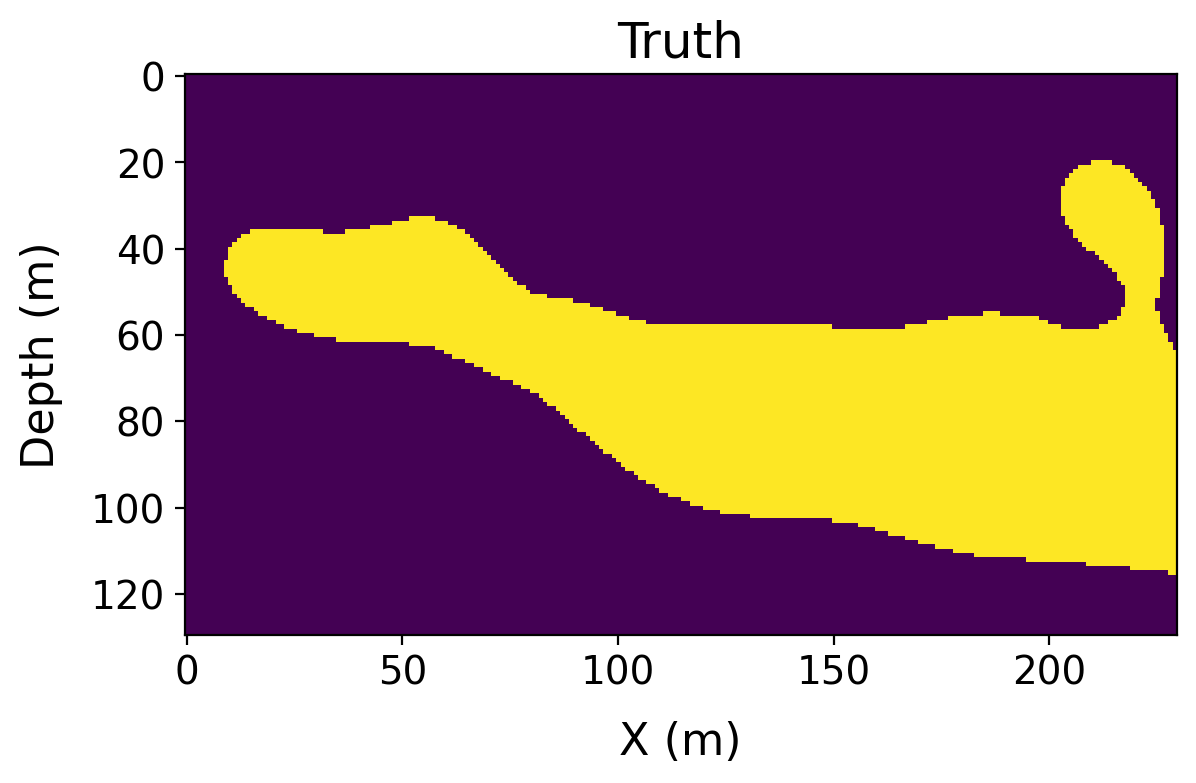

In [7]:
plt.imshow(truth)
plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

## Intrusion boreholes

In [8]:
borehole = pd.read_csv(path+'/data/Case2_intrusion/hole_contacts_UQ.csv')



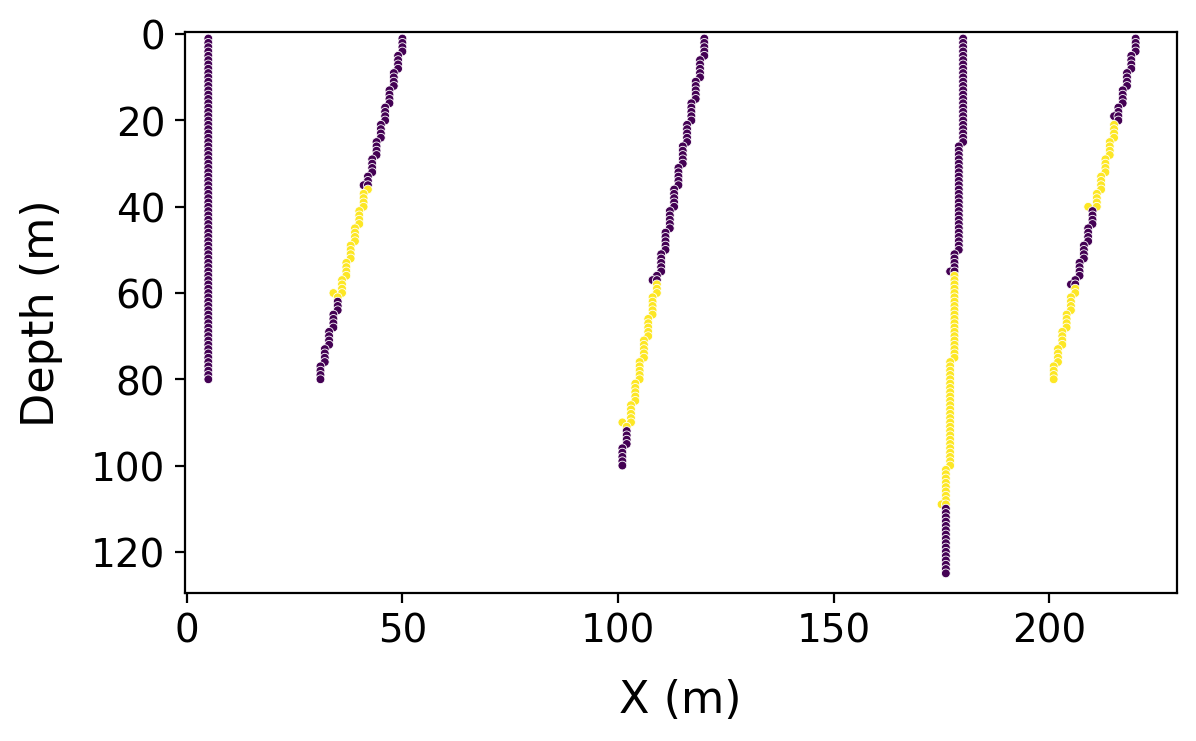

In [9]:
plt.imshow(truth, alpha = 0)
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

## Initial model 

In [10]:
x_dim, y_dim= truth.shape
print(truth.shape)
x0 = 65; a = 20  # x center, half width                                       
y0 = 115; b = 110  # y center, half height   

x = np.linspace(0, x_dim,x_dim)[:,None]  # x values of interest
y = np.linspace(0, y_dim,y_dim)[:]  # y values of interest, as a "column" array
ellipsoid = (((x-x0)/a)**2 + ((y-y0)/b)**2) <= 1  # True for points inside the ellipse
initial = ellipsoid*1

(130, 230)


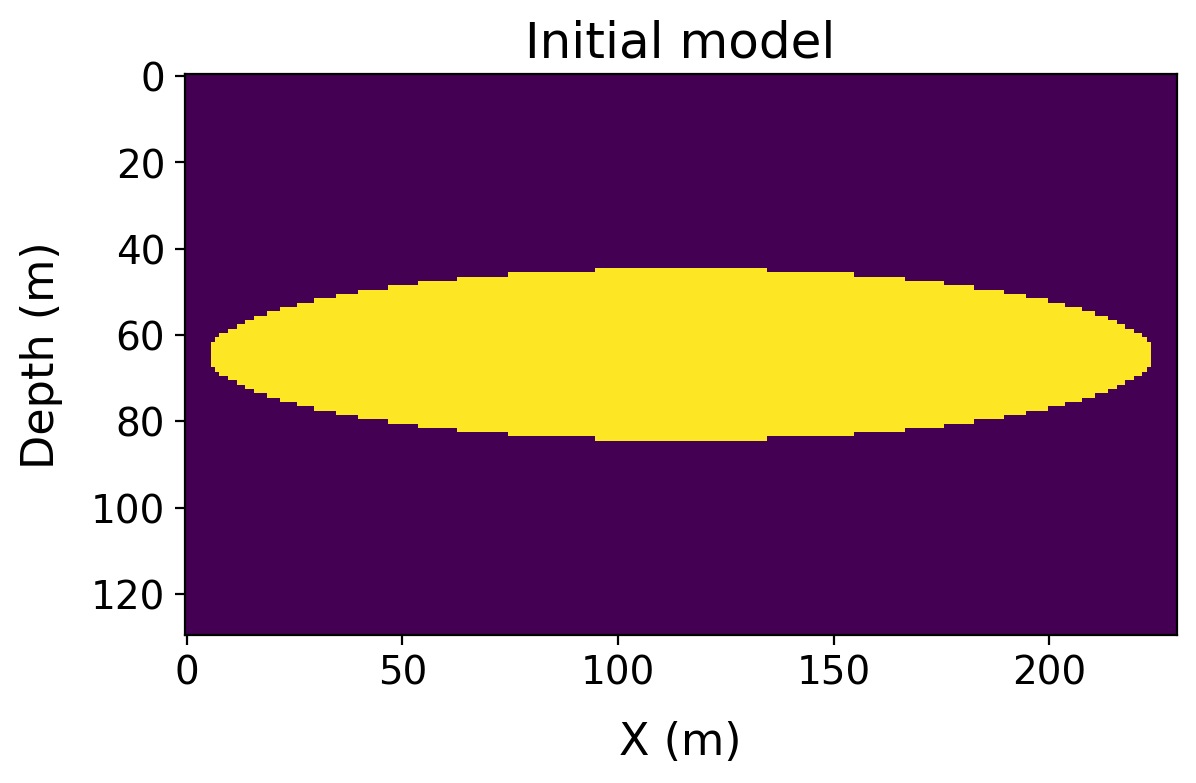

In [11]:
plt.imshow(initial)
plt.title('Initial model')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

# Trend estimation: MCMC on level sets M(x)

In [12]:
data = np.zeros(initial.shape)
data[:] = np.nan
data[np.array(borehole['depth'],dtype = 'int64'),np.array(borehole['x'],dtype = 'int64')]= truth[np.array(borehole['depth'],dtype = 'int64'),np.array(borehole['x'],dtype = 'int64')]#actual data
data[np.array(borehole[borehole['contacts']==1]['depth'],dtype = 'int64'),
     np.array(borehole[borehole['contacts']==1]['x'],dtype = 'int64')] = 0.5 # contact points

In [13]:
# initialized with the signed distance function 
initial = initial - 0.5
model = skfmm.distance(initial)

In [14]:
indicators_x_alpha = data[np.isfinite(data)]
indicators_x_alpha[indicators_x_alpha==0.5]=1

## signed dist at each borehole locations x_alpha
phi_x_alpha_ini = model[np.isfinite(data)]

## signed dist at contact locations x_beta
phi_x_beta_ini = model[data==0.5]

# calculate the loss 
loss_prev, o_ik_prev, o_bias_prev, o_var_prev =  loss_mean_function_v2(indicators_x_alpha,phi_x_alpha_ini,phi_x_beta_ini, model, data)
print(loss_prev)
sigma_coeff = 0.01
print('sigma = ', loss_prev*sigma_coeff)
print(o_ik_prev, o_bias_prev, o_var_prev)

1716.1877123546578
sigma =  17.161877123546578
1361.141111166757 51.75167354927869 303.29492763862237


In [119]:
iter_num = 3000
[model_cache, loss_cache, para_cache] = McMC_levelsets_2Dv2(model, data, 
                                                loss_function=loss_mean_function_v2,  
                                                sigma = 15, t_step = 1, iter_num = iter_num, 
                                                vel_range_x = [50, 100], vel_range_y = [50, 100],
                                                anisotropy_ang = [0, 180], num_mp = 0)
np.save('loss_cache.npy',loss_cache)
np.save('model_cache.npy',model_cache)
np.save('para_cache.npy',para_cache)

  1%|          | 21/3000 [00:06<15:44,  3.16it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 20: nan


  1%|▏         | 41/3000 [00:12<14:41,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 40: nan


  2%|▏         | 61/3000 [00:18<15:00,  3.26it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 60: nan


  3%|▎         | 81/3000 [00:24<14:34,  3.34it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 80: nan


  3%|▎         | 101/3000 [00:31<14:23,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 100: nan


  4%|▍         | 121/3000 [00:37<15:00,  3.20it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 120: nan


  5%|▍         | 141/3000 [00:43<15:24,  3.09it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 140: nan


  5%|▌         | 161/3000 [00:49<14:07,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 160: nan


  6%|▌         | 181/3000 [00:55<14:08,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 180: nan


  7%|▋         | 201/3000 [01:01<14:11,  3.29it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 200: nan


  7%|▋         | 221/3000 [01:08<14:22,  3.22it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 220: nan


  8%|▊         | 241/3000 [01:14<13:50,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 240: nan


  9%|▊         | 261/3000 [01:20<14:03,  3.25it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 260: nan


  9%|▉         | 281/3000 [01:26<13:28,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 280: nan


 10%|█         | 301/3000 [01:32<13:37,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 300: nan


 11%|█         | 321/3000 [01:38<13:31,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 320: nan


 11%|█▏        | 341/3000 [01:44<13:38,  3.25it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 340: nan


 12%|█▏        | 361/3000 [01:50<13:19,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 360: nan


 13%|█▎        | 381/3000 [01:57<13:22,  3.26it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 380: nan


 13%|█▎        | 401/3000 [02:03<14:28,  2.99it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 400: nan


 14%|█▍        | 421/3000 [02:09<13:04,  3.29it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 420: nan


 15%|█▍        | 441/3000 [02:15<12:55,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 440: nan


 15%|█▌        | 461/3000 [02:21<12:50,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 460: nan


 16%|█▌        | 481/3000 [02:28<12:41,  3.31it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 480: nan


 17%|█▋        | 501/3000 [02:34<12:25,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 500: nan


 17%|█▋        | 521/3000 [02:40<12:27,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 520: nan


 18%|█▊        | 541/3000 [02:46<12:16,  3.34it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 540: nan


 19%|█▊        | 561/3000 [02:52<12:37,  3.22it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 560: nan


 19%|█▉        | 581/3000 [02:59<12:01,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 580: nan


 20%|██        | 601/3000 [03:05<12:19,  3.24it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 600: nan


 21%|██        | 621/3000 [03:11<12:40,  3.13it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 620: nan


 21%|██▏       | 641/3000 [03:17<11:55,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 640: nan


 22%|██▏       | 661/3000 [03:23<11:53,  3.28it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 660: nan


 23%|██▎       | 681/3000 [03:29<11:29,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 680: nan


 23%|██▎       | 701/3000 [03:35<11:35,  3.31it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 700: nan


 24%|██▍       | 721/3000 [03:41<11:27,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 720: nan


 25%|██▍       | 741/3000 [03:47<11:19,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 740: nan


 25%|██▌       | 761/3000 [03:53<11:12,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 760: nan


 26%|██▌       | 781/3000 [04:00<11:25,  3.24it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 780: nan


 27%|██▋       | 801/3000 [04:06<11:31,  3.18it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 800: nan


 27%|██▋       | 821/3000 [04:12<10:58,  3.31it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 820: nan


 28%|██▊       | 841/3000 [04:18<10:48,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 840: nan


 29%|██▊       | 861/3000 [04:24<10:40,  3.34it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 860: nan


 29%|██▉       | 881/3000 [04:30<10:38,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 880: nan


 30%|███       | 901/3000 [04:36<10:32,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 900: nan


 31%|███       | 921/3000 [04:42<10:30,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 920: nan


 31%|███▏      | 941/3000 [04:49<10:31,  3.26it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 940: nan


 32%|███▏      | 961/3000 [04:55<10:29,  3.24it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 960: nan


 33%|███▎      | 981/3000 [05:01<10:07,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 980: nan


 33%|███▎      | 1001/3000 [05:07<11:28,  2.91it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1000: nan


 34%|███▍      | 1021/3000 [05:14<10:09,  3.24it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1020: nan


 35%|███▍      | 1041/3000 [05:20<10:13,  3.19it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1040: nan


 35%|███▌      | 1061/3000 [05:26<09:42,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1060: nan


 36%|███▌      | 1081/3000 [05:32<09:46,  3.27it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1080: nan


 37%|███▋      | 1101/3000 [05:38<09:35,  3.30it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1100: nan


 37%|███▋      | 1121/3000 [05:44<09:21,  3.34it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1120: nan


 38%|███▊      | 1141/3000 [05:50<09:36,  3.23it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1140: nan


 39%|███▊      | 1161/3000 [05:56<09:02,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1160: nan


 39%|███▉      | 1181/3000 [06:02<08:58,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1180: nan


 40%|████      | 1201/3000 [06:08<08:56,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1200: nan


 41%|████      | 1221/3000 [06:14<09:03,  3.28it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1220: nan


 41%|████▏     | 1241/3000 [06:20<08:39,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1240: nan


 42%|████▏     | 1261/3000 [06:26<08:46,  3.31it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1260: nan


 43%|████▎     | 1281/3000 [06:32<08:29,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1280: nan


 43%|████▎     | 1301/3000 [06:38<08:30,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1300: nan


 44%|████▍     | 1321/3000 [06:44<08:20,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1320: nan


 45%|████▍     | 1341/3000 [06:50<08:41,  3.18it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1340: nan


 45%|████▌     | 1361/3000 [06:56<08:05,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1360: nan


 46%|████▌     | 1381/3000 [07:02<08:00,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1380: nan


 47%|████▋     | 1401/3000 [07:08<08:02,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1400: nan


 47%|████▋     | 1421/3000 [07:14<07:50,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1420: nan


 48%|████▊     | 1441/3000 [07:20<07:41,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1440: nan


 49%|████▊     | 1461/3000 [07:26<07:33,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1460: nan


 49%|████▉     | 1481/3000 [07:32<07:34,  3.34it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1480: nan


 50%|█████     | 1501/3000 [07:38<07:22,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1500: nan


 51%|█████     | 1521/3000 [07:44<07:18,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1520: nan


 51%|█████▏    | 1541/3000 [07:50<08:12,  2.96it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1540: nan


 52%|█████▏    | 1561/3000 [07:56<07:08,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1560: nan


 53%|█████▎    | 1581/3000 [08:02<07:07,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1580: nan


 53%|█████▎    | 1601/3000 [08:08<07:00,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1600: nan


 54%|█████▍    | 1621/3000 [08:14<06:48,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1620: nan


 55%|█████▍    | 1641/3000 [08:20<06:44,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1640: nan


 55%|█████▌    | 1661/3000 [08:26<06:37,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1660: nan


 56%|█████▌    | 1681/3000 [08:32<06:30,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1680: nan


 57%|█████▋    | 1701/3000 [08:38<06:26,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1700: nan


 57%|█████▋    | 1721/3000 [08:44<06:20,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1720: nan


 58%|█████▊    | 1741/3000 [08:50<06:13,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1740: nan


 59%|█████▊    | 1761/3000 [08:56<06:07,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1760: nan


 59%|█████▉    | 1781/3000 [09:02<06:03,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1780: nan


 60%|██████    | 1801/3000 [09:08<05:53,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1800: nan


 61%|██████    | 1821/3000 [09:14<05:55,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1820: nan


 61%|██████▏   | 1841/3000 [09:20<05:55,  3.26it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1840: nan


 62%|██████▏   | 1861/3000 [09:26<05:48,  3.27it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1860: nan


 63%|██████▎   | 1881/3000 [09:32<05:38,  3.31it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1880: nan


 63%|██████▎   | 1901/3000 [09:38<05:23,  3.40it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1900: nan


 64%|██████▍   | 1921/3000 [09:44<05:18,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1920: nan


 65%|██████▍   | 1941/3000 [09:50<05:58,  2.95it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1940: nan


 65%|██████▌   | 1961/3000 [09:56<05:10,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1960: nan


 66%|██████▌   | 1981/3000 [10:02<05:01,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 1980: nan


 67%|██████▋   | 2000/3000 [10:07<04:53,  3.40it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2000: nan


 67%|██████▋   | 2021/3000 [10:14<04:55,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2020: nan


 68%|██████▊   | 2041/3000 [10:20<04:43,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2040: nan


 69%|██████▊   | 2061/3000 [10:26<04:39,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2060: nan


 69%|██████▉   | 2081/3000 [10:32<04:33,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2080: nan


 70%|███████   | 2101/3000 [10:38<04:30,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2100: nan


 71%|███████   | 2121/3000 [10:44<04:21,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2120: nan


 71%|███████▏  | 2141/3000 [10:50<04:13,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2140: nan


 72%|███████▏  | 2161/3000 [10:56<04:08,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2160: nan


 73%|███████▎  | 2181/3000 [11:01<04:02,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2180: nan


 73%|███████▎  | 2201/3000 [11:07<04:00,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2200: nan


 74%|███████▍  | 2221/3000 [11:13<03:50,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2220: nan


 75%|███████▍  | 2241/3000 [11:19<03:43,  3.40it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2240: nan


 75%|███████▌  | 2261/3000 [11:25<03:41,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2260: nan


 76%|███████▌  | 2281/3000 [11:31<03:34,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2280: nan


 77%|███████▋  | 2301/3000 [11:37<03:29,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2300: nan


 77%|███████▋  | 2321/3000 [11:43<03:22,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2320: nan


 78%|███████▊  | 2341/3000 [11:49<03:15,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2340: nan


 79%|███████▊  | 2361/3000 [11:55<03:09,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2360: nan


 79%|███████▉  | 2381/3000 [12:01<03:03,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2380: nan


 80%|████████  | 2401/3000 [12:07<02:59,  3.34it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2400: nan


 81%|████████  | 2421/3000 [12:13<02:53,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2420: nan


 81%|████████▏ | 2441/3000 [12:19<02:45,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2440: nan


 82%|████████▏ | 2461/3000 [12:25<02:39,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2460: nan


 83%|████████▎ | 2481/3000 [12:31<02:36,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2480: nan


 83%|████████▎ | 2501/3000 [12:37<02:25,  3.43it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2500: nan


 84%|████████▍ | 2521/3000 [12:43<02:24,  3.32it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2520: nan


 85%|████████▍ | 2541/3000 [12:49<02:23,  3.19it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2540: nan


 85%|████████▌ | 2561/3000 [12:55<02:08,  3.41it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2560: nan


 86%|████████▌ | 2581/3000 [13:01<02:09,  3.24it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2580: nan


 87%|████████▋ | 2601/3000 [13:08<02:01,  3.28it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2600: nan


 87%|████████▋ | 2621/3000 [13:14<01:59,  3.18it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2620: nan


 88%|████████▊ | 2641/3000 [13:20<01:50,  3.24it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2640: nan


 89%|████████▊ | 2661/3000 [13:26<01:42,  3.31it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2660: nan


 89%|████████▉ | 2681/3000 [13:32<01:44,  3.06it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2680: nan


 90%|█████████ | 2701/3000 [13:38<01:30,  3.31it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2700: nan


 91%|█████████ | 2721/3000 [13:44<01:23,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2720: nan


 91%|█████████▏| 2741/3000 [13:50<01:20,  3.21it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2740: nan


 92%|█████████▏| 2761/3000 [13:56<01:10,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2760: nan


 93%|█████████▎| 2781/3000 [14:02<01:05,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2780: nan


 93%|█████████▎| 2801/3000 [14:08<00:59,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2800: nan


 94%|█████████▍| 2821/3000 [14:14<00:53,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2820: nan


 95%|█████████▍| 2841/3000 [14:20<00:47,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2840: nan


 95%|█████████▌| 2861/3000 [14:26<00:41,  3.39it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2860: nan


 96%|█████████▌| 2881/3000 [14:32<00:35,  3.37it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2880: nan


 97%|█████████▋| 2901/3000 [14:37<00:29,  3.33it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2900: nan


 97%|█████████▋| 2921/3000 [14:43<00:23,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2920: nan


 98%|█████████▊| 2941/3000 [14:49<00:17,  3.35it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2940: nan


 99%|█████████▊| 2961/3000 [14:55<00:11,  3.38it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2960: nan


 99%|█████████▉| 2981/3000 [15:01<00:05,  3.36it/s]

Num_mp: 0Accept ratio: 1.0, Loss function at iter 2980: nan


100%|██████████| 3000/3000 [15:07<00:00,  3.31it/s]


In [15]:
loss_cache = np.load(path+'results/Case2_intrusion/0_loss_cache.npy')
model_cache = np.load(path+'results/Case2_intrusion/0_trend_cache.npy')
para_cache = np.load(path+'results/Case2_intrusion/0_para_cache.npy')

In [ ]:
# You can run multiple chains using this code block
import multiprocessing
iter_num = 3000

sigma = 15
input_list = [[model, data, loss_mean_function_v2, sigma,  1, iter_num, [20,50], [20,50],  [0,180], 13],
              [model, data, loss_mean_function_v2, sigma, 1, iter_num, [20,50], [20,50], [0,180], 14],
              [model, data, loss_mean_function_v2, sigma,  1, iter_num, [30,75], [30,75], [0,180], 15]]
              #[model, data, loss_mean_function_v2, sigma, 1, iter_num, [30,75], [30,75], [0,180], 16],
              #[model, data, loss_mean_function_v2, sigma,  1, iter_num, [50,100], [50,100], [0,180], 17],
              #[model, data, loss_mean_function_v2, sigma, 1, iter_num, [50,100], [50,100], [0,180], 18]]

# Trend estimation, McMC
# 6 runs
# the start indicate where we retrieve our velocity
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 6)
    result = pool.map(mp_non_stationary_implicit_2D,input_list)
    pool.close()

  0%|          | 18/30000 [00:15<7:27:59,  1.12it/s]/Users/justinleong/Documents/GitHub/data_knowledge_driven_trend_surface/notebook/../methods/implicit_perturb_2D.py:141: RuntimeWarning: overflow encountered in exp
  alpha = min(1,np.exp((loss_prev**2-loss_next**2)/(sigma**2)))
  0%|          | 20/30000 [00:19<10:25:59,  1.25s/it]

Num_mp: 18Accept ratio: 0.5789473684210527, Loss function at iter 20: 1341.687593846036
Num_mp: 17Accept ratio: 0.1578947368421053, Loss function at iter 20: 1605.4475797212351


  0%|          | 2/3000 [00:02<1:01:09,  1.22s/it]/Users/justinleong/Documents/GitHub/data_knowledge_driven_trend_surface/notebook/../methods/implicit_perturb_2D.py:141: RuntimeWarning: overflow encountered in exp
  alpha = min(1,np.exp((loss_prev**2-loss_next**2)/(sigma**2)))
  0%|          | 2/3000 [00:02<1:06:28,  1.33s/it]

Num_mp: 15Accept ratio: 0.26315789473684215, Loss function at iter 20: 1536.5132174368382
Num_mp: 16Accept ratio: 0.4736842105263158, Loss function at iter 20: 1544.7782948644362


  0%|          | 22/30000 [00:21<10:23:50,  1.25s/it]

Num_mp: 14Accept ratio: 0.631578947368421, Loss function at iter 20: 1402.0844848687875
Num_mp: 13Accept ratio: 0.5263157894736843, Loss function at iter 20: 1534.626975221849


  0%|          | 9/3000 [00:11<1:07:37,  1.36s/it]/Users/justinleong/Documents/GitHub/data_knowledge_driven_trend_surface/notebook/../methods/implicit_perturb_2D.py:141: RuntimeWarning: overflow encountered in exp
  alpha = min(1,np.exp((loss_prev**2-loss_next**2)/(sigma**2)))
  0%|          | 28/30000 [00:30<11:04:20,  1.33s/it]/Users/justinleong/Documents/GitHub/data_knowledge_driven_trend_surface/notebook/../methods/implicit_perturb_2D.py:141: RuntimeWarning: overflow encountered in exp
  alpha = min(1,np.exp((loss_prev**2-loss_next**2)/(sigma**2)))
  0%|          | 39/30000 [00:45<11:41:09,  1.40s/it]

Num_mp: 18Accept ratio: 0.3157894736842105, Loss function at iter 20: 1640.2295807537125
Num_mp: 17Accept ratio: 0.42105263157894735, Loss function at iter 20: 1550.2440785317349


  1%|          | 21/3000 [00:27<1:08:32,  1.38s/it]

Num_mp: 16Accept ratio: 0.5263157894736843, Loss function at iter 20: 1657.3853149337178
Num_mp: 18Accept ratio: 0.5128205128205128, Loss function at iter 40: 1133.286858633873
Num_mp: 15Accept ratio: 0.368421052631579, Loss function at iter 20: 1652.216030067242
Num_mp: 17Accept ratio: 0.4358974358974359, Loss function at iter 40: 1420.068903615628


  0%|          | 40/30000 [00:46<11:21:29,  1.36s/it]

Num_mp: 14Accept ratio: 0.631578947368421, Loss function at iter 20: 1557.1918007003264


  1%|          | 22/3000 [00:29<1:13:45,  1.49s/it]

Num_mp: 13Accept ratio: 0.5789473684210527, Loss function at iter 20: 1549.9527127271024


  1%|          | 22/3000 [00:30<1:16:48,  1.55s/it]t]

Num_mp: 15Accept ratio: 0.3589743589743589, Loss function at iter 40: 1471.3036695949108


  0%|          | 40/30000 [00:48<13:19:12,  1.60s/it]

Num_mp: 16Accept ratio: 0.41025641025641024, Loss function at iter 40: 1465.2922560359923


  0%|          | 42/30000 [00:49<12:14:11,  1.47s/it]

Num_mp: 14Accept ratio: 0.641025641025641, Loss function at iter 40: 1272.029881237181
Num_mp: 13Accept ratio: 0.5384615384615384, Loss function at iter 40: 1455.1653849668528


  0%|          | 41/30000 [00:50<13:02:38,  1.57s/it]/Users/justinleong/Documents/GitHub/data_knowledge_driven_trend_surface/notebook/../methods/implicit_perturb_2D.py:141: RuntimeWarning: overflow encountered in exp
  alpha = min(1,np.exp((loss_prev**2-loss_next**2)/(sigma**2)))
  1%|▏         | 41/3000 [00:56<1:10:31,  1.43s/it]t]

Num_mp: 17Accept ratio: 0.46153846153846156, Loss function at iter 40: 1410.330608661096


  1%|▏         | 39/3000 [00:56<1:16:12,  1.54s/it]t]

Num_mp: 18Accept ratio: 0.46153846153846156, Loss function at iter 40: 1333.9109762119567


  0%|          | 61/30000 [01:14<11:48:04,  1.42s/it]

Num_mp: 18Accept ratio: 0.5254237288135593, Loss function at iter 60: 1038.0166311411313


  0%|          | 59/30000 [01:14<12:45:33,  1.53s/it]

Num_mp: 17Accept ratio: 0.47457627118644063, Loss function at iter 60: 1295.2775155564793


  0%|          | 61/30000 [01:14<12:12:42,  1.47s/it]

Num_mp: 15Accept ratio: 0.4358974358974359, Loss function at iter 40: 1582.7439654501727


  1%|▏         | 42/3000 [00:57<1:11:53,  1.46s/it]t]

Num_mp: 16Accept ratio: 0.5128205128205128, Loss function at iter 40: 1507.6231885231862


  1%|▏         | 41/3000 [00:59<1:14:34,  1.51s/it]t]

Num_mp: 14Accept ratio: 0.5384615384615384, Loss function at iter 40: 1376.6950015245343
Num_mp: 15Accept ratio: 0.3728813559322034, Loss function at iter 60: 1426.5516320253105
Num_mp: 13Accept ratio: 0.641025641025641, Loss function at iter 40: 1313.5338514918208
Num_mp: 16Accept ratio: 0.4576271186440678, Loss function at iter 60: 1319.9598791499589


  0%|          | 61/30000 [01:19<12:32:37,  1.51s/it]

Num_mp: 14Accept ratio: 0.6440677966101696, Loss function at iter 60: 1174.902279015646


  0%|          | 61/30000 [01:20<12:36:13,  1.52s/it]

Num_mp: 13Accept ratio: 0.5254237288135593, Loss function at iter 60: 1313.3352260214835


  0%|          | 80/30000 [01:41<11:17:55,  1.36s/it]

Num_mp: 17Accept ratio: 0.4576271186440678, Loss function at iter 60: 1331.6361039483068
Num_mp: 18Accept ratio: 0.49367088607594933, Loss function at iter 80: 978.2960328948947


  0%|          | 78/30000 [01:41<11:21:38,  1.37s/it]

Num_mp: 18Accept ratio: 0.47457627118644063, Loss function at iter 60: 1221.3145021521905


  2%|▏         | 60/3000 [01:24<1:07:05,  1.37s/it]t]

Num_mp: 17Accept ratio: 0.4683544303797469, Loss function at iter 80: 1227.6886656025981


  2%|▏         | 62/3000 [01:25<1:03:55,  1.31s/it]t]

Num_mp: 15Accept ratio: 0.423728813559322, Loss function at iter 60: 1485.1831998432706


  2%|▏         | 59/3000 [01:25<1:07:47,  1.38s/it]t]

Num_mp: 16Accept ratio: 0.5254237288135593, Loss function at iter 60: 1439.1896998687125


  2%|▏         | 64/3000 [01:27<1:03:55,  1.31s/it]t]

Num_mp: 15Accept ratio: 0.40506329113924056, Loss function at iter 80: 1359.0695447540354


  0%|          | 79/30000 [01:45<12:13:57,  1.47s/it]

Num_mp: 16Accept ratio: 0.5063291139240507, Loss function at iter 80: 1214.5403233757506


  2%|▏         | 61/3000 [01:28<1:13:20,  1.50s/it]t]

Num_mp: 14Accept ratio: 0.576271186440678, Loss function at iter 60: 1265.8148143071835
Num_mp: 13Accept ratio: 0.5254237288135593, Loss function at iter 60: 1217.3183440095281


  0%|          | 81/30000 [01:48<12:09:20,  1.46s/it]

Num_mp: 14Accept ratio: 0.620253164556962, Loss function at iter 80: 1074.523667076059


  0%|          | 81/30000 [01:49<12:02:07,  1.45s/it]

Num_mp: 13Accept ratio: 0.5189873417721519, Loss function at iter 80: 1198.6099557878758


  0%|          | 87/30000 [01:57<11:38:40,  1.40s/it]/Users/justinleong/Documents/GitHub/data_knowledge_driven_trend_surface/notebook/../methods/implicit_perturb_2D.py:141: RuntimeWarning: overflow encountered in exp
  alpha = min(1,np.exp((loss_prev**2-loss_next**2)/(sigma**2)))
  3%|▎         | 81/3000 [01:50<1:05:45,  1.35s/it]t]]

Num_mp: 17Accept ratio: 0.44303797468354433, Loss function at iter 80: 1261.3634642835766


  0%|          | 97/30000 [02:08<11:42:29,  1.41s/it]]

Num_mp: 18Accept ratio: 0.4949494949494949, Loss function at iter 100: 938.0295074360741
Num_mp: 18Accept ratio: 0.5063291139240507, Loss function at iter 80: 1144.9321987900266


  0%|          | 98/30000 [02:09<11:39:13,  1.40s/it]]

Num_mp: 17Accept ratio: 0.505050505050505, Loss function at iter 100: 1087.907631282423


  3%|▎         | 83/3000 [01:53<1:08:15,  1.40s/it]it]

Num_mp: 15Accept ratio: 0.430379746835443, Loss function at iter 80: 1271.859564093853


  3%|▎         | 81/3000 [01:53<1:12:24,  1.49s/it]

Num_mp: 16Accept ratio: 0.5189873417721519, Loss function at iter 80: 1311.5911027247678


  0%|          | 101/30000 [02:14<12:07:21,  1.46s/it]

Num_mp: 16Accept ratio: 0.5151515151515151, Loss function at iter 100: 1125.5006267909307
Num_mp: 15Accept ratio: 0.41414141414141414, Loss function at iter 100: 1251.42060547526


  0%|          | 105/30000 [02:15<12:00:00,  1.45s/it]

Num_mp: 14Accept ratio: 0.5189873417721519, Loss function at iter 80: 1203.0921356648817
Num_mp: 13Accept ratio: 0.5063291139240507, Loss function at iter 80: 1124.3901541778323


  3%|▎         | 84/3000 [01:58<1:12:54,  1.50s/it]/Users/justinleong/Documents/GitHub/data_knowledge_driven_trend_surface/notebook/../methods/implicit_perturb_2D.py:141: RuntimeWarning: overflow encountered in exp
  alpha = min(1,np.exp((loss_prev**2-loss_next**2)/(sigma**2)))
  0%|          | 101/30000 [02:18<12:27:16,  1.50s/it]

Num_mp: 14Accept ratio: 0.5555555555555556, Loss function at iter 100: 1037.4101565783062


  0%|          | 101/30000 [02:18<12:41:52,  1.53s/it]

Num_mp: 13Accept ratio: 0.505050505050505, Loss function at iter 100: 1108.535323711712


  0%|          | 116/30000 [02:36<12:17:19,  1.48s/it]

Num_mp: 17Accept ratio: 0.4545454545454546, Loss function at iter 100: 1219.0574774385257


  3%|▎         | 101/3000 [02:18<1:07:18,  1.39s/it]t]

Num_mp: 18Accept ratio: 0.48484848484848486, Loss function at iter 100: 1076.7342606289026
Num_mp: 18Accept ratio: 0.5042016806722689, Loss function at iter 120: 847.2247801374692


  3%|▎         | 99/3000 [02:19<1:09:42,  1.44s/it]it]

Num_mp: 17Accept ratio: 0.4789915966386554, Loss function at iter 120: 1044.5332045656085


  0%|          | 119/30000 [02:40<11:48:46,  1.42s/it]

Num_mp: 16Accept ratio: 0.5454545454545454, Loss function at iter 100: 1144.9229484057064
Num_mp: 15Accept ratio: 0.4747474747474747, Loss function at iter 100: 1105.6069694235673


  0%|          | 121/30000 [02:42<11:28:55,  1.38s/it]

Num_mp: 16Accept ratio: 0.5126050420168067, Loss function at iter 120: 1023.5408308944395
Num_mp: 15Accept ratio: 0.45378151260504207, Loss function at iter 120: 1137.5580170001492


  0%|          | 119/30000 [02:44<11:44:52,  1.42s/it]

Num_mp: 14Accept ratio: 0.5757575757575757, Loss function at iter 100: 1086.7283174626543


  3%|▎         | 101/3000 [02:27<1:08:15,  1.41s/it]t]

Num_mp: 13Accept ratio: 0.505050505050505, Loss function at iter 100: 1086.4681250038516


  0%|          | 121/30000 [02:48<12:49:01,  1.54s/it]

Num_mp: 14Accept ratio: 0.5042016806722689, Loss function at iter 120: 995.3737756644879
Num_mp: 13Accept ratio: 0.5294117647058824, Loss function at iter 120: 967.6046099307925


  4%|▍         | 117/3000 [02:47<1:14:23,  1.55s/it]t]

Num_mp: 17Accept ratio: 0.4957983193277311, Loss function at iter 120: 1143.9449257217486


  0%|          | 140/30000 [03:05<12:22:50,  1.49s/it]

Num_mp: 18Accept ratio: 0.5126050420168067, Loss function at iter 120: 948.3827684644755
Num_mp: 18Accept ratio: 0.49640287769784175, Loss function at iter 140: 786.8496979737345


  0%|          | 133/30000 [03:07<12:34:37,  1.52s/it]

Num_mp: 17Accept ratio: 0.48201438848920863, Loss function at iter 140: 1008.2380886561149


  0%|          | 139/30000 [03:10<11:56:38,  1.44s/it]

Num_mp: 15Accept ratio: 0.5042016806722689, Loss function at iter 120: 1020.0419540011846
Num_mp: 16Accept ratio: 0.5126050420168067, Loss function at iter 120: 1087.7006188512428


  0%|          | 137/30000 [03:12<11:53:57,  1.43s/it]

Num_mp: 16Accept ratio: 0.5035971223021583, Loss function at iter 140: 952.6783670358736


  4%|▍         | 119/3000 [02:55<1:09:02,  1.44s/it]t]

Num_mp: 15Accept ratio: 0.4676258992805755, Loss function at iter 140: 1075.6199986489762


  0%|          | 143/30000 [03:15<10:57:15,  1.32s/it]

Num_mp: 14Accept ratio: 0.5798319327731092, Loss function at iter 120: 1006.7441781992918


  4%|▍         | 129/3000 [02:58<1:02:08,  1.30s/it]t]

Num_mp: 13Accept ratio: 0.5294117647058824, Loss function at iter 120: 945.0083037922826


  4%|▍         | 130/3000 [03:00<1:01:47,  1.29s/it]t]

Num_mp: 14Accept ratio: 0.5107913669064748, Loss function at iter 140: 942.8870034300559


  1%|          | 151/30000 [03:19<10:41:24,  1.29s/it]

Num_mp: 13Accept ratio: 0.539568345323741, Loss function at iter 140: 910.5233829066523


  1%|          | 155/30000 [03:31<11:04:06,  1.34s/it]

Num_mp: 17Accept ratio: 0.49640287769784175, Loss function at iter 140: 1107.4185257052097


  1%|          | 161/30000 [03:32<10:50:50,  1.31s/it]

Num_mp: 18Accept ratio: 0.4968553459119497, Loss function at iter 160: 765.521257459998
Num_mp: 18Accept ratio: 0.525179856115108, Loss function at iter 140: 879.5992616675371


  5%|▍         | 142/3000 [03:15<1:02:03,  1.30s/it]t]

Num_mp: 17Accept ratio: 0.48427672955974843, Loss function at iter 160: 966.5581220919402


  1%|          | 159/30000 [03:37<11:13:28,  1.35s/it]

Num_mp: 15Accept ratio: 0.525179856115108, Loss function at iter 140: 909.0541221437076
Num_mp: 16Accept ratio: 0.5179856115107914, Loss function at iter 140: 1005.7136799527495


  5%|▍         | 147/3000 [03:21<1:01:45,  1.30s/it]t]

Num_mp: 16Accept ratio: 0.5220125786163522, Loss function at iter 160: 926.7117302865656


  5%|▍         | 143/3000 [03:22<1:05:31,  1.38s/it]t]

Num_mp: 15Accept ratio: 0.4779874213836478, Loss function at iter 160: 921.5136801862739


  5%|▍         | 141/3000 [03:26<1:06:45,  1.40s/it]t]

Num_mp: 14Accept ratio: 0.5899280575539568, Loss function at iter 140: 961.7335053650577


  5%|▍         | 141/3000 [03:26<1:06:48,  1.40s/it]t]

Num_mp: 13Accept ratio: 0.5179856115107914, Loss function at iter 140: 879.3991755765676


  5%|▌         | 152/3000 [03:28<1:02:16,  1.31s/it]t]

Num_mp: 14Accept ratio: 0.5220125786163522, Loss function at iter 160: 873.9569497575329


  1%|          | 166/30000 [03:46<11:24:24,  1.38s/it]

Num_mp: 13Accept ratio: 0.5220125786163522, Loss function at iter 160: 853.6720341332519


  5%|▌         | 151/3000 [03:40<1:06:34,  1.40s/it]t]

Num_mp: 17Accept ratio: 0.49056603773584906, Loss function at iter 160: 1072.1596525632033
Num_mp: 18Accept ratio: 0.5083798882681565, Loss function at iter 180: 702.8901780299038


  5%|▌         | 152/3000 [03:41<1:06:08,  1.39s/it]t]

Num_mp: 18Accept ratio: 0.5157232704402516, Loss function at iter 160: 839.6252824125074


  1%|          | 175/30000 [03:59<11:21:40,  1.37s/it]

Num_mp: 17Accept ratio: 0.4860335195530726, Loss function at iter 180: 909.2184673847157


  5%|▌         | 161/3000 [03:46<1:03:52,  1.35s/it]t]

Num_mp: 15Accept ratio: 0.5345911949685535, Loss function at iter 160: 841.2192816416331


  5%|▌         | 161/3000 [03:47<1:04:39,  1.37s/it]t]

Num_mp: 16Accept ratio: 0.5345911949685535, Loss function at iter 160: 910.4701334388301


  6%|▌         | 167/3000 [03:49<1:03:41,  1.35s/it]t]

Num_mp: 16Accept ratio: 0.5083798882681565, Loss function at iter 180: 905.7147510366817


  1%|          | 176/30000 [04:07<11:25:46,  1.38s/it]

Num_mp: 15Accept ratio: 0.4748603351955307, Loss function at iter 180: 841.1671475313073


  6%|▌         | 166/3000 [03:53<1:03:44,  1.35s/it]t]

Num_mp: 14Accept ratio: 0.5786163522012578, Loss function at iter 160: 934.4217156842031


  6%|▌         | 171/3000 [03:54<1:02:58,  1.34s/it]t]

Num_mp: 13Accept ratio: 0.5220125786163522, Loss function at iter 160: 816.977255194282


  5%|▌         | 163/3000 [03:57<1:06:40,  1.41s/it]t]

Num_mp: 14Accept ratio: 0.4860335195530726, Loss function at iter 180: 835.3893541134611


  6%|▌         | 168/3000 [03:56<1:03:52,  1.35s/it]t]

Num_mp: 13Accept ratio: 0.5251396648044693, Loss function at iter 180: 775.8597654161949


  6%|▌         | 175/3000 [04:06<1:06:11,  1.41s/it]t]

Num_mp: 17Accept ratio: 0.4804469273743017, Loss function at iter 180: 1030.226370675646


  6%|▌         | 176/3000 [04:07<1:06:20,  1.41s/it]t]

Num_mp: 18Accept ratio: 0.4974874371859297, Loss function at iter 200: 669.1256668653511


  6%|▌         | 181/3000 [04:07<1:02:20,  1.33s/it]t]

Num_mp: 18Accept ratio: 0.5307262569832403, Loss function at iter 180: 777.7036891476984


  6%|▌         | 182/3000 [04:08<1:03:54,  1.36s/it]t]

Num_mp: 17Accept ratio: 0.4623115577889447, Loss function at iter 200: 892.8972971403374


  6%|▌         | 181/3000 [04:14<1:03:29,  1.35s/it]t]

Num_mp: 15Accept ratio: 0.541899441340782, Loss function at iter 180: 752.1220224106


  1%|          | 194/30000 [04:32<11:42:37,  1.41s/it]

Num_mp: 16Accept ratio: 0.5363128491620112, Loss function at iter 180: 850.2416370929727


  1%|          | 201/30000 [04:34<11:05:27,  1.34s/it]

Num_mp: 16Accept ratio: 0.49246231155778897, Loss function at iter 200: 861.3030810555015


  1%|          | 209/30000 [04:35<10:54:27,  1.32s/it]

Num_mp: 15Accept ratio: 0.46733668341708545, Loss function at iter 200: 786.0437309446936


  6%|▌         | 186/3000 [04:22<1:05:54,  1.41s/it]t]

Num_mp: 14Accept ratio: 0.5642458100558659, Loss function at iter 180: 849.0215366381603


  6%|▌         | 187/3000 [04:23<1:05:12,  1.39s/it]t]

Num_mp: 13Accept ratio: 0.5139664804469274, Loss function at iter 180: 765.0629998314109


  1%|          | 206/30000 [04:42<11:34:26,  1.40s/it]

Num_mp: 14Accept ratio: 0.4773869346733668, Loss function at iter 200: 785.080053323581


  1%|          | 201/30000 [04:43<11:44:44,  1.42s/it]

Num_mp: 13Accept ratio: 0.5276381909547738, Loss function at iter 200: 680.9644220642879


  6%|▋         | 188/3000 [04:33<1:07:32,  1.44s/it]t]

Num_mp: 17Accept ratio: 0.4974874371859297, Loss function at iter 200: 953.6000357175807


  1%|          | 221/30000 [04:51<11:09:49,  1.35s/it]

Num_mp: 18Accept ratio: 0.5068493150684932, Loss function at iter 220: 626.3902426342986


  1%|          | 207/30000 [04:52<12:33:45,  1.52s/it]

Num_mp: 18Accept ratio: 0.5226130653266332, Loss function at iter 200: 694.0649100022241


  7%|▋         | 202/3000 [04:35<1:06:51,  1.43s/it]t]

Num_mp: 17Accept ratio: 0.4748858447488584, Loss function at iter 220: 853.5696425339045


  7%|▋         | 200/3000 [04:43<1:13:03,  1.57s/it]t]

Num_mp: 15Accept ratio: 0.5326633165829145, Loss function at iter 200: 710.8818489761444


  7%|▋         | 207/3000 [04:44<1:08:11,  1.46s/it]t]

Num_mp: 16Accept ratio: 0.5276381909547738, Loss function at iter 200: 810.2660704045504


  7%|▋         | 197/3000 [04:47<1:11:17,  1.53s/it]t]

Num_mp: 16Accept ratio: 0.5022831050228311, Loss function at iter 220: 804.4194534106849


  1%|          | 221/30000 [05:05<12:19:11,  1.49s/it]

Num_mp: 15Accept ratio: 0.4657534246575342, Loss function at iter 220: 744.9603387813472


  1%|          | 233/30000 [05:09<11:23:52,  1.38s/it]

Num_mp: 14Accept ratio: 0.5577889447236181, Loss function at iter 200: 753.7783772635905


  7%|▋         | 201/3000 [04:54<1:07:53,  1.46s/it]t]

Num_mp: 13Accept ratio: 0.5025125628140703, Loss function at iter 200: 727.5195325410208


  7%|▋         | 203/3000 [04:55<1:07:04,  1.44s/it]t]

Num_mp: 14Accept ratio: 0.45662100456621, Loss function at iter 220: 769.6773707001074


  1%|          | 221/30000 [05:14<11:58:15,  1.45s/it]

Num_mp: 13Accept ratio: 0.5022831050228311, Loss function at iter 220: 650.9858629332869


  7%|▋         | 220/3000 [05:02<1:03:09,  1.36s/it]t]

Num_mp: 17Accept ratio: 0.5114155251141552, Loss function at iter 220: 893.5337968765648


  7%|▋         | 215/3000 [05:03<1:04:56,  1.40s/it]t]

Num_mp: 18Accept ratio: 0.502092050209205, Loss function at iter 240: 575.2988374980915


  7%|▋         | 222/3000 [05:03<1:03:20,  1.37s/it]t]

Num_mp: 18Accept ratio: 0.5251141552511416, Loss function at iter 220: 647.4939079170052


  1%|          | 227/30000 [05:21<11:53:41,  1.44s/it]

Num_mp: 17Accept ratio: 0.4728033472803347, Loss function at iter 240: 806.6607427069607


  7%|▋         | 221/3000 [05:11<1:04:43,  1.40s/it]t]

Num_mp: 15Accept ratio: 0.5251141552511416, Loss function at iter 220: 671.5907229887296


  1%|          | 248/30000 [05:30<11:11:58,  1.36s/it]

Num_mp: 16Accept ratio: 0.5251141552511416, Loss function at iter 220: 760.8927466876653


  1%|          | 240/30000 [05:32<11:45:12,  1.42s/it]

Num_mp: 16Accept ratio: 0.506276150627615, Loss function at iter 240: 731.9641192343373


  1%|          | 241/30000 [05:34<11:59:04,  1.45s/it]

Num_mp: 15Accept ratio: 0.4728033472803347, Loss function at iter 240: 707.7284940381289


  8%|▊         | 228/3000 [05:21<1:06:10,  1.43s/it]t]

Num_mp: 14Accept ratio: 0.5388127853881279, Loss function at iter 220: 734.5866006908207


  7%|▋         | 221/3000 [05:23<1:07:56,  1.47s/it]t]

Num_mp: 13Accept ratio: 0.4840182648401826, Loss function at iter 220: 706.3197089075227


  8%|▊         | 237/3000 [05:24<1:03:08,  1.37s/it]t]

Num_mp: 14Accept ratio: 0.4560669456066946, Loss function at iter 240: 746.1132388197196


  7%|▋         | 222/3000 [05:25<1:07:58,  1.47s/it]t]

Num_mp: 13Accept ratio: 0.497907949790795, Loss function at iter 240: 625.3355149575082


  8%|▊         | 225/3000 [05:29<1:05:54,  1.42s/it]t]

Num_mp: 17Accept ratio: 0.506276150627615, Loss function at iter 240: 856.7132710583579


  1%|          | 245/30000 [05:47<11:51:51,  1.44s/it]

Num_mp: 18Accept ratio: 0.49034749034749037, Loss function at iter 260: 530.0009647829046


  1%|          | 261/30000 [05:48<10:54:28,  1.32s/it]

Num_mp: 17Accept ratio: 0.45945945945945943, Loss function at iter 260: 785.936820294984
Num_mp: 18Accept ratio: 0.5104602510460251, Loss function at iter 240: 611.2482242207734


  1%|          | 251/30000 [05:56<10:55:13,  1.32s/it]

Num_mp: 15Accept ratio: 0.5230125523012552, Loss function at iter 240: 645.9034868936054


  8%|▊         | 233/3000 [05:40<1:04:09,  1.39s/it]t]

Num_mp: 16Accept ratio: 0.5355648535564854, Loss function at iter 240: 714.8952480746434


  1%|          | 261/30000 [05:59<10:56:29,  1.32s/it]

Num_mp: 16Accept ratio: 0.5096525096525096, Loss function at iter 260: 684.4333506559881


  1%|          | 262/30000 [06:00<10:48:27,  1.31s/it]

Num_mp: 15Accept ratio: 0.46718146718146714, Loss function at iter 260: 675.8391999184196


  1%|          | 275/30000 [06:06<10:36:16,  1.28s/it]

Num_mp: 14Accept ratio: 0.5104602510460251, Loss function at iter 240: 712.4920542646154


  8%|▊         | 249/3000 [05:50<1:00:14,  1.31s/it]t]

Num_mp: 13Accept ratio: 0.4895397489539749, Loss function at iter 240: 668.84474422308


  1%|          | 278/30000 [06:09<10:25:43,  1.26s/it]

Num_mp: 14Accept ratio: 0.4555984555984556, Loss function at iter 260: 705.9555523214115


  1%|          | 261/30000 [06:10<11:09:08,  1.35s/it]

Num_mp: 13Accept ratio: 0.5057915057915058, Loss function at iter 260: 575.6619177384308


  9%|▊         | 261/3000 [05:55<58:48,  1.29s/it]/it]

Num_mp: 17Accept ratio: 0.5019305019305019, Loss function at iter 260: 835.1699336276972


  1%|          | 264/30000 [06:13<11:06:18,  1.34s/it]

Num_mp: 18Accept ratio: 0.4946236559139785, Loss function at iter 280: 481.919597417922


  1%|          | 264/30000 [06:14<11:10:56,  1.35s/it]

Num_mp: 18Accept ratio: 0.49034749034749037, Loss function at iter 260: 600.8756352658635
Num_mp: 17Accept ratio: 0.4623655913978495, Loss function at iter 280: 733.2793024937187


  1%|          | 288/30000 [06:22<10:29:44,  1.27s/it]

Num_mp: 15Accept ratio: 0.528957528957529, Loss function at iter 260: 617.9166971138787


  1%|          | 272/30000 [06:24<11:00:32,  1.33s/it]

Num_mp: 16Accept ratio: 0.528957528957529, Loss function at iter 260: 648.6036476244092


  1%|          | 281/30000 [06:25<10:50:28,  1.31s/it]

Num_mp: 16Accept ratio: 0.5089605734767024, Loss function at iter 280: 644.9385567679979


  1%|          | 291/30000 [06:27<10:36:52,  1.29s/it]

Num_mp: 15Accept ratio: 0.4767025089605734, Loss function at iter 280: 626.266697641544


  9%|▊         | 261/3000 [06:16<1:00:53,  1.33s/it]t]

Num_mp: 14Accept ratio: 0.5173745173745175, Loss function at iter 260: 654.7378088086863


  9%|▉         | 271/3000 [06:17<59:17,  1.30s/it]/it]

Num_mp: 13Accept ratio: 0.49034749034749037, Loss function at iter 260: 612.612053876166


  9%|▉         | 272/3000 [06:18<58:37,  1.29s/it]/it]

Num_mp: 14Accept ratio: 0.4444444444444444, Loss function at iter 280: 699.5633311023367


  1%|          | 299/30000 [06:37<10:28:22,  1.27s/it]

Num_mp: 13Accept ratio: 0.4946236559139785, Loss function at iter 280: 536.8815619161419


  1%|          | 282/30000 [06:38<11:14:40,  1.36s/it]

Num_mp: 17Accept ratio: 0.5089605734767024, Loss function at iter 280: 775.2429762908464


  1%|          | 291/30000 [06:38<10:43:48,  1.30s/it]

Num_mp: 18Accept ratio: 0.4816053511705686, Loss function at iter 300: 472.7453563916192


  1%|          | 301/30000 [06:39<10:34:55,  1.28s/it]

Num_mp: 18Accept ratio: 0.48745519713261654, Loss function at iter 280: 578.6939679854296
Num_mp: 17Accept ratio: 0.4816053511705686, Loss function at iter 300: 690.0521068883322


  9%|▉         | 272/3000 [06:31<1:00:23,  1.33s/it]t]

Num_mp: 15Accept ratio: 0.5304659498207885, Loss function at iter 280: 589.6892327687424


  9%|▉         | 272/3000 [06:32<59:22,  1.31s/it]  t]

Num_mp: 16Accept ratio: 0.5304659498207885, Loss function at iter 280: 611.8319286271212


  1%|          | 301/30000 [06:51<10:31:57,  1.28s/it]

Num_mp: 16Accept ratio: 0.5150501672240803, Loss function at iter 300: 622.309414441326


  1%|          | 301/30000 [06:53<10:57:59,  1.33s/it]

Num_mp: 15Accept ratio: 0.4782608695652174, Loss function at iter 300: 610.3493274755909


  9%|▉         | 281/3000 [06:43<1:00:13,  1.33s/it]t]

Num_mp: 14Accept ratio: 0.5053763440860215, Loss function at iter 280: 621.1390380513735


  9%|▉         | 281/3000 [06:44<1:00:33,  1.34s/it]t]

Num_mp: 13Accept ratio: 0.5053763440860215, Loss function at iter 280: 560.7694455016746


  1%|          | 301/30000 [07:03<10:56:08,  1.33s/it]

Num_mp: 14Accept ratio: 0.46153846153846156, Loss function at iter 300: 629.489967775983
Num_mp: 17Accept ratio: 0.5150501672240803, Loss function at iter 300: 745.2608224695834


  1%|          | 301/30000 [07:04<11:15:48,  1.37s/it]

Num_mp: 13Accept ratio: 0.4882943143812709, Loss function at iter 300: 492.5143983939034
Num_mp: 18Accept ratio: 0.48275862068965514, Loss function at iter 320: 439.02564353545927


 10%|█         | 302/3000 [06:47<57:10,  1.27s/it]/it]

Num_mp: 17Accept ratio: 0.4796238244514106, Loss function at iter 320: 663.7911671333496


  1%|          | 302/30000 [07:05<11:13:12,  1.36s/it]

Num_mp: 18Accept ratio: 0.4916387959866221, Loss function at iter 300: 550.3174828246699


  1%|          | 329/30000 [07:14<10:31:56,  1.28s/it]

Num_mp: 15Accept ratio: 0.5183946488294314, Loss function at iter 300: 566.141236031685


 10%|█         | 301/3000 [06:58<58:49,  1.31s/it]/it]

Num_mp: 16Accept ratio: 0.5217391304347826, Loss function at iter 300: 593.653740594026


  1%|          | 321/30000 [07:18<11:34:30,  1.40s/it]

Num_mp: 16Accept ratio: 0.5141065830721003, Loss function at iter 320: 592.1831722077477


 10%|▉         | 294/3000 [07:02<1:07:59,  1.51s/it]t]

Num_mp: 15Accept ratio: 0.4796238244514106, Loss function at iter 320: 590.7864878946295


  1%|          | 328/30000 [07:28<11:42:44,  1.42s/it]

Num_mp: 14Accept ratio: 0.4983277591973244, Loss function at iter 300: 579.6181532144897


  1%|          | 328/30000 [07:30<11:33:11,  1.40s/it]

Num_mp: 17Accept ratio: 0.5078369905956113, Loss function at iter 320: 710.4007697712252


  1%|          | 340/30000 [07:30<11:27:53,  1.39s/it]

Num_mp: 13Accept ratio: 0.5050167224080268, Loss function at iter 300: 486.82391233563277


 11%|█         | 320/3000 [07:13<1:01:04,  1.37s/it]

Num_mp: 18Accept ratio: 0.4837758112094396, Loss function at iter 340: 419.41443563849805


  1%|          | 329/30000 [07:31<11:36:43,  1.41s/it]

Num_mp: 17Accept ratio: 0.47787610619469023, Loss function at iter 340: 628.5204989758923


 11%|█         | 322/3000 [07:14<1:02:43,  1.41s/it]t]

Num_mp: 14Accept ratio: 0.4670846394984326, Loss function at iter 320: 610.3711918805274
Num_mp: 18Accept ratio: 0.49529780564263326, Loss function at iter 320: 489.493502179062


  1%|          | 331/30000 [07:32<11:59:52,  1.46s/it]

Num_mp: 13Accept ratio: 0.48589341692789967, Loss function at iter 320: 442.67384772224125


  1%|          | 328/30000 [07:43<11:58:20,  1.45s/it]

Num_mp: 15Accept ratio: 0.5172413793103448, Loss function at iter 320: 532.674105104484


  1%|          | 330/30000 [07:45<11:48:47,  1.43s/it]

Num_mp: 16Accept ratio: 0.5203761755485894, Loss function at iter 320: 554.7872821644049


  1%|          | 341/30000 [07:47<11:54:22,  1.45s/it]

Num_mp: 16Accept ratio: 0.5103244837758112, Loss function at iter 340: 554.4862725278531


 11%|█         | 332/3000 [07:29<1:02:30,  1.41s/it]t]

KeyboardInterrupt: 

  1%|          | 332/30000 [07:48<12:10:07,  1.48s/it]

Num_mp: 15Accept ratio: 0.4837758112094396, Loss function at iter 340: 561.5347201631366


 11%|█         | 321/3000 [07:40<1:03:35,  1.42s/it]t]

Num_mp: 14Accept ratio: 0.49529780564263326, Loss function at iter 320: 526.7709367558292


 11%|█▏        | 340/3000 [07:40<58:48,  1.33s/it]/it]

Num_mp: 17Accept ratio: 0.504424778761062, Loss function at iter 340: 656.9149186447753


  1%|          | 348/30000 [07:58<11:15:48,  1.37s/it]

Num_mp: 18Accept ratio: 0.48189415041782735, Loss function at iter 360: 407.9059953726153
Num_mp: 17Accept ratio: 0.47075208913649025, Loss function at iter 360: 618.0908987368697


  1%|          | 350/30000 [07:59<11:31:21,  1.40s/it]

Num_mp: 18Accept ratio: 0.4985250737463127, Loss function at iter 340: 452.40260006038267


 11%|█         | 321/3000 [07:42<1:03:53,  1.43s/it]

Num_mp: 13Accept ratio: 0.5078369905956113, Loss function at iter 320: 431.2250467587053


 11%|█         | 323/3000 [07:43<1:03:18,  1.42s/it]t]

Num_mp: 14Accept ratio: 0.4690265486725663, Loss function at iter 340: 560.1660164198565


  1%|          | 341/30000 [08:02<12:02:33,  1.46s/it]

Num_mp: 13Accept ratio: 0.48672566371681414, Loss function at iter 340: 392.03942969072097


 11%|█▏        | 341/3000 [07:53<1:01:05,  1.38s/it]t]

Num_mp: 15Accept ratio: 0.5073746312684366, Loss function at iter 340: 517.55896882825


 11%|█▏        | 341/3000 [07:54<1:00:51,  1.37s/it]t]

Num_mp: 16Accept ratio: 0.5221238938053097, Loss function at iter 340: 513.3140126358462


  1%|          | 373/30000 [08:14<11:20:04,  1.38s/it]

Num_mp: 16Accept ratio: 0.5069637883008357, Loss function at iter 360: 543.9279259789238


 12%|█▏        | 345/3000 [07:58<1:03:48,  1.44s/it]t]

Num_mp: 15Accept ratio: 0.48189415041782735, Loss function at iter 360: 535.4658254582242


 12%|█▏        | 361/3000 [08:07<58:54,  1.34s/it]  t]

Num_mp: 17Accept ratio: 0.49303621169916434, Loss function at iter 360: 602.0558067390853


 11%|█▏        | 339/3000 [08:08<1:04:17,  1.45s/it]t]

Num_mp: 18Accept ratio: 0.4854881266490765, Loss function at iter 380: 381.58686122043736
Num_mp: 17Accept ratio: 0.47229551451187335, Loss function at iter 380: 577.1153003245555


 11%|█▏        | 341/3000 [08:09<1:05:07,  1.47s/it]t]

Num_mp: 18Accept ratio: 0.49582172701949856, Loss function at iter 360: 429.10195606128246
Num_mp: 14Accept ratio: 0.4985250737463127, Loss function at iter 340: 498.2805188441796


 11%|█▏        | 341/3000 [08:11<1:03:31,  1.43s/it]t]

Num_mp: 13Accept ratio: 0.504424778761062, Loss function at iter 340: 402.64603175353307


 11%|█▏        | 342/3000 [08:12<1:05:29,  1.48s/it]t]

Num_mp: 14Accept ratio: 0.4623955431754875, Loss function at iter 360: 545.3119012066201


 12%|█▏        | 354/3000 [08:13<1:03:27,  1.44s/it]t]

Num_mp: 13Accept ratio: 0.4874651810584958, Loss function at iter 360: 366.6542255413666


  1%|▏         | 391/30000 [08:39<10:43:33,  1.30s/it]

Num_mp: 15Accept ratio: 0.4986072423398329, Loss function at iter 360: 503.7194511124747


  1%|          | 368/30000 [08:41<11:24:51,  1.39s/it]

Num_mp: 16Accept ratio: 0.532033426183844, Loss function at iter 360: 457.558223440642


  1%|▏         | 381/30000 [08:43<11:13:03,  1.36s/it]

Num_mp: 16Accept ratio: 0.503957783641161, Loss function at iter 380: 526.4189993256222


 12%|█▏        | 364/3000 [08:27<58:26,  1.33s/it]t]t]

Num_mp: 15Accept ratio: 0.48021108179419525, Loss function at iter 380: 503.294778859654


 13%|█▎        | 380/3000 [08:34<57:10,  1.31s/it]/it]

Num_mp: 17Accept ratio: 0.4934036939313984, Loss function at iter 380: 569.6811040550033


  1%|▏         | 401/30000 [08:52<10:28:16,  1.27s/it]

Num_mp: 18Accept ratio: 0.48120300751879697, Loss function at iter 400: 367.9770170733362


  1%|▏         | 377/30000 [08:53<10:59:17,  1.34s/it]

Num_mp: 17Accept ratio: 0.46616541353383456, Loss function at iter 400: 556.8782855647023
Num_mp: 18Accept ratio: 0.4854881266490765, Loss function at iter 380: 390.3059110268455


  1%|▏         | 390/30000 [08:55<10:53:18,  1.32s/it]

Num_mp: 14Accept ratio: 0.4986072423398329, Loss function at iter 360: 453.5181627745218


 12%|█▏        | 361/3000 [08:39<1:00:49,  1.38s/it]t]

Num_mp: 13Accept ratio: 0.49582172701949856, Loss function at iter 360: 376.4924097734525


  1%|▏         | 392/30000 [08:58<11:14:50,  1.37s/it]

Num_mp: 14Accept ratio: 0.4538258575197889, Loss function at iter 380: 526.8319469700461


  1%|▏         | 381/30000 [08:58<11:28:50,  1.40s/it]

Num_mp: 13Accept ratio: 0.4854881266490765, Loss function at iter 380: 335.2274934144312


 13%|█▎        | 380/3000 [08:48<59:07,  1.35s/it]/it]

Num_mp: 15Accept ratio: 0.4907651715039578, Loss function at iter 380: 486.7317421269693


 13%|█▎        | 381/3000 [08:49<58:22,  1.34s/it]/it]

Num_mp: 16Accept ratio: 0.5329815303430079, Loss function at iter 380: 428.9038503336317


  1%|▏         | 414/30000 [09:09<10:35:28,  1.29s/it]

Num_mp: 16Accept ratio: 0.5062656641604011, Loss function at iter 400: 515.3024795027551


 12%|█▏        | 373/3000 [08:54<1:00:03,  1.37s/it]t]

Num_mp: 15Accept ratio: 0.4837092731829574, Loss function at iter 400: 466.09904531975985


 13%|█▎        | 401/3000 [08:59<55:21,  1.28s/it]/it]

Num_mp: 17Accept ratio: 0.49624060150375937, Loss function at iter 400: 528.7612411567367


  1%|▏         | 406/30000 [09:18<11:14:52,  1.37s/it]

Num_mp: 18Accept ratio: 0.48926014319809075, Loss function at iter 420: 342.7852745844648


  1%|▏         | 408/30000 [09:18<10:46:52,  1.31s/it]

Num_mp: 17Accept ratio: 0.4606205250596659, Loss function at iter 420: 524.5822003231026


 13%|█▎        | 402/3000 [09:01<56:08,  1.30s/it]/it]

Num_mp: 18Accept ratio: 0.48621553884711777, Loss function at iter 400: 347.8609657146363


  1%|▏         | 424/30000 [09:22<10:44:09,  1.31s/it]

Num_mp: 14Accept ratio: 0.4854881266490765, Loss function at iter 380: 426.8335523851397


 14%|█▎        | 405/3000 [09:06<56:59,  1.32s/it]t]t]

Num_mp: 13Accept ratio: 0.4934036939313984, Loss function at iter 380: 361.6160156631394


  1%|▏         | 413/30000 [09:25<10:59:11,  1.34s/it]

Num_mp: 14Accept ratio: 0.4486215538847118, Loss function at iter 400: 512.5571768304411


 14%|█▎        | 406/3000 [09:07<55:45,  1.29s/it]

Num_mp: 13Accept ratio: 0.4837092731829574, Loss function at iter 400: 297.55083999395237


  1%|▏         | 417/30000 [09:33<11:02:47,  1.34s/it]

Num_mp: 15Accept ratio: 0.48621553884711777, Loss function at iter 400: 473.39833054037035


 13%|█▎        | 389/3000 [09:16<1:01:04,  1.40s/it]t]

Num_mp: 16Accept ratio: 0.5338345864661654, Loss function at iter 400: 410.70283673303425


  1%|▏         | 419/30000 [09:36<11:19:13,  1.38s/it]

Num_mp: 16Accept ratio: 0.5059665871121719, Loss function at iter 420: 494.3970157841766


  1%|▏         | 410/30000 [09:39<11:37:58,  1.42s/it]

Num_mp: 15Accept ratio: 0.4844868735083532, Loss function at iter 420: 428.24847680712577


 13%|█▎        | 396/3000 [09:26<59:44,  1.38s/it]  t]

Num_mp: 17Accept ratio: 0.4940334128878282, Loss function at iter 420: 489.805093216307


  1%|▏         | 427/30000 [09:44<11:17:11,  1.37s/it]

Num_mp: 18Accept ratio: 0.48974943052391795, Loss function at iter 440: 328.49714480356886


 14%|█▍        | 422/3000 [09:27<55:57,  1.30s/it]/it]

Num_mp: 17Accept ratio: 0.46697038724373574, Loss function at iter 440: 498.2798535952131


 14%|█▍        | 421/3000 [09:27<57:15,  1.33s/it]t]t]

Num_mp: 18Accept ratio: 0.48687350835322196, Loss function at iter 420: 329.1753844933874


 14%|█▍        | 414/3000 [09:33<1:01:48,  1.43s/it]t]

Num_mp: 14Accept ratio: 0.49624060150375937, Loss function at iter 400: 373.8315479172194


  1%|▏         | 433/30000 [09:53<11:40:48,  1.42s/it]

Num_mp: 13Accept ratio: 0.4987468671679198, Loss function at iter 400: 308.5504708778591


 13%|█▎        | 403/3000 [09:37<1:03:44,  1.47s/it]t]

Num_mp: 14Accept ratio: 0.45107398568019097, Loss function at iter 420: 502.1734751716941


 14%|█▍        | 429/3000 [09:37<58:53,  1.37s/it]  t]

Num_mp: 13Accept ratio: 0.48926014319809075, Loss function at iter 420: 272.27604105654746


 14%|█▍        | 421/3000 [09:43<59:39,  1.39s/it]/it]

Num_mp: 15Accept ratio: 0.48687350835322196, Loss function at iter 420: 459.44626297638285


 14%|█▎        | 407/3000 [09:43<1:01:21,  1.42s/it]t]

Num_mp: 16Accept ratio: 0.5250596658711217, Loss function at iter 420: 398.3088070101233


 15%|█▍        | 436/3000 [09:46<56:59,  1.33s/it]/it]

Num_mp: 16Accept ratio: 0.5056947608200455, Loss function at iter 440: 463.82671537817714


  1%|▏         | 429/30000 [10:07<12:02:34,  1.47s/it]

Num_mp: 15Accept ratio: 0.4715261958997722, Loss function at iter 440: 419.10542345550374


  1%|▏         | 444/30000 [10:11<11:25:21,  1.39s/it]

Num_mp: 17Accept ratio: 0.4943052391799544, Loss function at iter 440: 458.5754771643701


 15%|█▍        | 440/3000 [09:54<57:53,  1.36s/it]t]t]

Num_mp: 18Accept ratio: 0.485838779956427, Loss function at iter 460: 313.2481860911521
Num_mp: 17Accept ratio: 0.4575163398692811, Loss function at iter 460: 491.4719407794634


 15%|█▍        | 441/3000 [09:55<58:24,  1.37s/it]t]t]

Num_mp: 18Accept ratio: 0.48974943052391795, Loss function at iter 440: 314.47086199531185


 14%|█▍        | 421/3000 [10:02<1:00:36,  1.41s/it]t]

Num_mp: 14Accept ratio: 0.4916467780429594, Loss function at iter 420: 358.6997228953825


 14%|█▍        | 421/3000 [10:04<1:03:29,  1.48s/it]t]

Num_mp: 13Accept ratio: 0.5059665871121719, Loss function at iter 420: 264.98911848547027


  2%|▏         | 469/30000 [10:22<11:30:28,  1.40s/it]

Num_mp: 14Accept ratio: 0.44646924829157175, Loss function at iter 440: 479.35565511410005


  2%|▏         | 455/30000 [10:23<11:40:36,  1.42s/it]

Num_mp: 13Accept ratio: 0.48747152619589973, Loss function at iter 440: 240.71600464802407


 15%|█▍        | 441/3000 [10:11<58:32,  1.37s/it]  t]

Num_mp: 15Accept ratio: 0.4829157175398633, Loss function at iter 440: 434.9476215093782


 15%|█▍        | 442/3000 [10:12<58:42,  1.38s/it]t]t]

Num_mp: 16Accept ratio: 0.530751708428246, Loss function at iter 440: 365.1367399409471


  2%|▏         | 476/30000 [10:32<11:16:35,  1.37s/it]

Num_mp: 16Accept ratio: 0.5032679738562091, Loss function at iter 460: 447.3303042231062


 14%|█▍        | 431/3000 [10:17<1:02:47,  1.47s/it]t]

Num_mp: 15Accept ratio: 0.47276688453159044, Loss function at iter 460: 400.7203926351801


  2%|▏         | 480/30000 [10:38<11:26:36,  1.40s/it]

Num_mp: 17Accept ratio: 0.4901960784313726, Loss function at iter 460: 439.5822475431384


 14%|█▍        | 434/3000 [10:21<1:02:40,  1.47s/it]t]

Num_mp: 18Accept ratio: 0.48643006263048016, Loss function at iter 480: 296.8643796893747


 15%|█▌        | 460/3000 [10:21<59:13,  1.40s/it]/it]

Num_mp: 17Accept ratio: 0.4530271398747391, Loss function at iter 480: 485.93669075418245


 15%|█▌        | 461/3000 [10:23<59:32,  1.41s/it]/it]

Num_mp: 18Accept ratio: 0.485838779956427, Loss function at iter 460: 300.71216517085026


  2%|▏         | 473/30000 [10:49<11:38:44,  1.42s/it]

Num_mp: 14Accept ratio: 0.4943052391799544, Loss function at iter 440: 307.5461312511457


  2%|▏         | 474/30000 [10:51<11:59:37,  1.46s/it]

Num_mp: 13Accept ratio: 0.5034168564920274, Loss function at iter 440: 227.50075223303395


 16%|█▌        | 469/3000 [10:34<59:39,  1.41s/it]/it]

Num_mp: 14Accept ratio: 0.44880174291939, Loss function at iter 460: 458.46179721068955


  2%|▏         | 474/30000 [10:53<11:46:25,  1.44s/it]

Num_mp: 13Accept ratio: 0.4901960784313726, Loss function at iter 460: 194.78184474239924


 15%|█▍        | 445/3000 [10:39<1:06:05,  1.55s/it]t]

Num_mp: 15Accept ratio: 0.4771241830065359, Loss function at iter 460: 425.55011863237485


 15%|█▌        | 461/3000 [10:41<1:05:12,  1.54s/it]t]

Num_mp: 16Accept ratio: 0.5272331154684096, Loss function at iter 460: 353.9150044330648


  2%|▏         | 467/30000 [11:01<12:30:11,  1.52s/it]

Num_mp: 16Accept ratio: 0.4989561586638831, Loss function at iter 480: 434.63036730060776


  2%|▏         | 469/30000 [11:04<12:24:28,  1.51s/it]

Num_mp: 15Accept ratio: 0.48225469728601256, Loss function at iter 480: 374.959088533255


 16%|█▌        | 481/3000 [10:48<59:02,  1.41s/it]  t]

Num_mp: 17Accept ratio: 0.48643006263048016, Loss function at iter 480: 421.7515060931668


 16%|█▌        | 482/3000 [10:49<59:38,  1.42s/it]/it]

Num_mp: 18Accept ratio: 0.47895791583166336, Loss function at iter 500: 292.4641328038496


 15%|█▌        | 452/3000 [10:50<1:03:40,  1.50s/it]t]

Num_mp: 17Accept ratio: 0.4589178356713427, Loss function at iter 500: 463.86798137158996


  2%|▏         | 471/30000 [11:09<12:29:01,  1.52s/it]

Num_mp: 18Accept ratio: 0.48643006263048016, Loss function at iter 480: 289.605569110635


 15%|█▌        | 461/3000 [11:03<1:07:26,  1.59s/it]t]

Num_mp: 14Accept ratio: 0.4880174291938998, Loss function at iter 460: 299.20311682805414


 16%|█▋        | 490/3000 [11:04<1:02:03,  1.48s/it]t]

Num_mp: 13Accept ratio: 0.5098039215686274, Loss function at iter 460: 194.27374101880375


 16%|█▋        | 492/3000 [11:04<1:02:08,  1.49s/it]t]

Num_mp: 14Accept ratio: 0.45093945720250517, Loss function at iter 480: 421.26060831755854


 16%|█▌        | 478/3000 [11:06<1:01:52,  1.47s/it]t]

Num_mp: 13Accept ratio: 0.4989561586638831, Loss function at iter 480: 151.22811652093066


 16%|█▌        | 481/3000 [11:09<1:02:02,  1.48s/it]t]

Num_mp: 15Accept ratio: 0.47390396659707723, Loss function at iter 480: 407.41151951921825


 16%|█▌        | 481/3000 [11:11<1:01:40,  1.47s/it]t]

Num_mp: 16Accept ratio: 0.5198329853862214, Loss function at iter 480: 332.2708375467633


 17%|█▋        | 498/3000 [11:13<1:00:22,  1.45s/it]t]

Num_mp: 16Accept ratio: 0.498997995991984, Loss function at iter 500: 416.1251056357751


  2%|▏         | 488/30000 [11:33<12:43:11,  1.55s/it]

Num_mp: 15Accept ratio: 0.49098196392785576, Loss function at iter 500: 325.8820097310754


 16%|█▌        | 471/3000 [11:18<1:04:22,  1.53s/it]t]

Num_mp: 17Accept ratio: 0.4949899799599199, Loss function at iter 500: 388.2586462900184


  2%|▏         | 489/30000 [11:37<12:52:16,  1.57s/it]

Num_mp: 18Accept ratio: 0.47294589178356716, Loss function at iter 520: 270.84067289401526
Num_mp: 17Accept ratio: 0.46893787575150303, Loss function at iter 520: 449.86332852955735


 17%|█▋        | 503/3000 [11:20<59:40,  1.43s/it]  t]

Num_mp: 18Accept ratio: 0.4829659318637275, Loss function at iter 500: 283.97158457023124


  2%|▏         | 500/30000 [11:51<12:03:08,  1.47s/it]

Num_mp: 14Accept ratio: 0.48851774530271397, Loss function at iter 480: 260.72797077904033


 17%|█▋        | 498/3000 [11:34<1:01:48,  1.48s/it]t]

Num_mp: 14Accept ratio: 0.45691382765531063, Loss function at iter 500: 370.6032029079629
Num_mp: 13Accept ratio: 0.5093945720250521, Loss function at iter 480: 169.85477547548788


  2%|▏         | 517/30000 [11:54<11:39:05,  1.42s/it]

Num_mp: 13Accept ratio: 0.503006012024048, Loss function at iter 500: 127.85571084004155


 17%|█▋        | 514/3000 [11:39<1:00:05,  1.45s/it]t]

Num_mp: 15Accept ratio: 0.46693386773547096, Loss function at iter 500: 395.90744151757974


 17%|█▋        | 501/3000 [11:40<1:00:46,  1.46s/it]t]

Num_mp: 16Accept ratio: 0.5210420841683367, Loss function at iter 500: 319.77641007852736


  2%|▏         | 521/30000 [12:00<11:42:50,  1.43s/it]

Num_mp: 16Accept ratio: 0.498997995991984, Loss function at iter 520: 404.99181412259736


 16%|█▋        | 488/3000 [11:45<1:02:26,  1.49s/it]t]

Num_mp: 15Accept ratio: 0.503006012024048, Loss function at iter 520: 303.4363180818019


  2%|▏         | 523/30000 [12:03<11:59:23,  1.46s/it]

Num_mp: 17Accept ratio: 0.4869739478957916, Loss function at iter 520: 365.47055555240246


  2%|▏         | 541/30000 [12:05<11:34:55,  1.42s/it]

Num_mp: 17Accept ratio: 0.4589178356713427, Loss function at iter 540: 439.88746671102285
Num_mp: 18Accept ratio: 0.46893787575150303, Loss function at iter 540: 256.6483111276125


 17%|█▋        | 523/3000 [11:48<57:53,  1.40s/it]t]t]

Num_mp: 18Accept ratio: 0.4929859719438878, Loss function at iter 520: 274.5493241760298


  2%|▏         | 552/30000 [12:20<11:30:53,  1.41s/it]

Num_mp: 14Accept ratio: 0.4829659318637275, Loss function at iter 500: 238.1420581463935


  2%|▏         | 521/30000 [12:22<12:06:53,  1.48s/it]

Num_mp: 14Accept ratio: 0.44889779559118237, Loss function at iter 520: 340.764907639429
Num_mp: 13Accept ratio: 0.503006012024048, Loss function at iter 500: 159.39313624301698


 17%|█▋        | 519/3000 [12:07<1:11:03,  1.72s/it]t]

Num_mp: 13Accept ratio: 0.5090180360721444, Loss function at iter 520: 95.06466195574974


 17%|█▋        | 504/3000 [12:09<1:09:44,  1.68s/it]t]

Num_mp: 15Accept ratio: 0.46092184368737477, Loss function at iter 520: 385.598465522307


 18%|█▊        | 538/3000 [12:10<1:07:35,  1.65s/it]t]

Num_mp: 16Accept ratio: 0.5150300601202404, Loss function at iter 520: 297.7505399490186


 18%|█▊        | 537/3000 [12:13<1:07:53,  1.65s/it]t]

Num_mp: 16Accept ratio: 0.498997995991984, Loss function at iter 540: 395.96539781210316


 18%|█▊        | 525/3000 [12:15<1:10:03,  1.70s/it]t]

Num_mp: 17Accept ratio: 0.4869739478957916, Loss function at iter 540: 352.03084579425945


  2%|▏         | 543/30000 [12:34<13:42:40,  1.68s/it]

Num_mp: 15Accept ratio: 0.5130260521042085, Loss function at iter 540: 251.6583684288632


 18%|█▊        | 540/3000 [12:18<1:07:24,  1.64s/it]t]

Num_mp: 18Accept ratio: 0.4649298597194389, Loss function at iter 560: 241.08604398863213
Num_mp: 17Accept ratio: 0.4589178356713427, Loss function at iter 560: 428.8390659819068


  2%|▏         | 545/30000 [12:37<13:39:45,  1.67s/it]

Num_mp: 18Accept ratio: 0.4889779559118237, Loss function at iter 540: 247.39923207734327


 18%|█▊        | 537/3000 [12:37<1:12:17,  1.76s/it]t]

Num_mp: 14Accept ratio: 0.4829659318637275, Loss function at iter 520: 204.77021292119173


  2%|▏         | 555/30000 [12:57<14:20:16,  1.75s/it]

Num_mp: 14Accept ratio: 0.43887775551102204, Loss function at iter 540: 320.62744624602857
Num_mp: 13Accept ratio: 0.498997995991984, Loss function at iter 520: 125.93292298957678


  2%|▏         | 576/30000 [13:00<14:26:06,  1.77s/it]

Num_mp: 15Accept ratio: 0.45490981963927857, Loss function at iter 540: 363.8389244047145
Num_mp: 13Accept ratio: 0.5130260521042085, Loss function at iter 540: 77.23153363498416


  2%|▏         | 542/30000 [13:02<15:01:12,  1.84s/it]

Num_mp: 16Accept ratio: 0.5150300601202404, Loss function at iter 540: 286.76085279097003


  2%|▏         | 561/30000 [13:04<14:23:47,  1.76s/it]

Num_mp: 16Accept ratio: 0.49699398797595196, Loss function at iter 560: 373.3777038682838


 18%|█▊        | 526/3000 [12:49<1:13:36,  1.79s/it]t]

Num_mp: 17Accept ratio: 0.4809619238476954, Loss function at iter 560: 335.64342507724336


  2%|▏         | 561/30000 [13:08<14:58:58,  1.83s/it]

Num_mp: 15Accept ratio: 0.5230460921843687, Loss function at iter 560: 248.26773900235474
Num_mp: 17Accept ratio: 0.46292585170340683, Loss function at iter 580: 400.91515098828546


  2%|▏         | 581/30000 [13:09<14:24:02,  1.76s/it]

Num_mp: 18Accept ratio: 0.46893787575150303, Loss function at iter 580: 225.39357245155847


  2%|▏         | 548/30000 [13:11<15:33:11,  1.90s/it]

Num_mp: 18Accept ratio: 0.4889779559118237, Loss function at iter 560: 238.39486640000152


  2%|▏         | 595/30000 [13:33<13:48:24,  1.69s/it]

Num_mp: 14Accept ratio: 0.4809619238476954, Loss function at iter 540: 167.22754797387952


  2%|▏         | 561/30000 [13:35<14:49:54,  1.81s/it]

Num_mp: 14Accept ratio: 0.4308617234468938, Loss function at iter 560: 305.95048997513265


 18%|█▊        | 541/3000 [13:17<1:17:23,  1.89s/it]t]

Num_mp: 13Accept ratio: 0.49699398797595196, Loss function at iter 540: 113.81156090240373


 18%|█▊        | 543/3000 [13:19<1:16:01,  1.86s/it]t]

Num_mp: 15Accept ratio: 0.45490981963927857, Loss function at iter 560: 348.3894239726906


 19%|█▉        | 576/3000 [13:20<1:10:11,  1.74s/it]t]

Num_mp: 13Accept ratio: 0.5210420841683367, Loss function at iter 560: 71.09058645132446


 19%|█▉        | 577/3000 [13:21<1:10:19,  1.74s/it]t]

Num_mp: 16Accept ratio: 0.5150300601202404, Loss function at iter 560: 255.8834957670041


  2%|▏         | 599/30000 [13:40<14:46:11,  1.81s/it]

Num_mp: 16Accept ratio: 0.4889779559118237, Loss function at iter 580: 358.32712881891604


 19%|█▉        | 564/3000 [13:24<1:13:45,  1.82s/it]t]

Num_mp: 17Accept ratio: 0.47494989979959923, Loss function at iter 580: 332.44036009219815


  2%|▏         | 601/30000 [13:43<14:05:37,  1.73s/it]

Num_mp: 17Accept ratio: 0.4529058116232465, Loss function at iter 600: 391.5462210655187


  2%|▏         | 601/30000 [13:44<14:33:40,  1.78s/it]

Num_mp: 18Accept ratio: 0.4649298597194389, Loss function at iter 600: 211.39286404334055


  2%|▏         | 581/30000 [13:44<14:29:07,  1.77s/it]

Num_mp: 15Accept ratio: 0.5210420841683367, Loss function at iter 580: 218.8026288357


 19%|█▉        | 581/3000 [13:28<1:09:27,  1.72s/it]t]

Num_mp: 18Accept ratio: 0.47895791583166336, Loss function at iter 580: 223.6997287191973


 19%|█▊        | 561/3000 [13:51<1:09:15,  1.70s/it]t]

Num_mp: 14Accept ratio: 0.47494989979959923, Loss function at iter 560: 155.85327419470406


  2%|▏         | 596/30000 [14:10<14:02:39,  1.72s/it]

Num_mp: 15Accept ratio: 0.44889779559118237, Loss function at iter 580: 319.14752180001506
Num_mp: 14Accept ratio: 0.4228456913827655, Loss function at iter 580: 281.60111495046135


  2%|▏         | 618/30000 [14:11<13:26:17,  1.65s/it]

Num_mp: 13Accept ratio: 0.5050100200400802, Loss function at iter 560: 109.53418506467837


 20%|██        | 600/3000 [13:55<1:04:35,  1.61s/it]t]

Num_mp: 13Accept ratio: 0.5210420841683367, Loss function at iter 580: 58.1420499508931
Num_mp: 16Accept ratio: 0.5110220440881763, Loss function at iter 580: 246.88192113407888


  2%|▏         | 582/30000 [14:15<13:48:05,  1.69s/it]

Num_mp: 17Accept ratio: 0.4709418837675351, Loss function at iter 600: 300.07319053714014
Num_mp: 16Accept ratio: 0.4829659318637275, Loss function at iter 600: 345.31407546503533


  2%|▏         | 621/30000 [14:16<13:07:45,  1.61s/it]

Num_mp: 17Accept ratio: 0.46092184368737477, Loss function at iter 620: 370.9751865039836


 19%|█▉        | 566/3000 [14:00<1:10:25,  1.74s/it]t]

Num_mp: 18Accept ratio: 0.46893787575150303, Loss function at iter 620: 194.72215090324582


  2%|▏         | 601/30000 [14:19<14:05:43,  1.73s/it]

Num_mp: 15Accept ratio: 0.5210420841683367, Loss function at iter 600: 194.76051726127494
Num_mp: 18Accept ratio: 0.47895791583166336, Loss function at iter 600: 212.18133736909056


 20%|██        | 600/3000 [14:26<1:10:37,  1.77s/it]t]

Num_mp: 14Accept ratio: 0.48496993987975956, Loss function at iter 580: 111.99688538942998


 20%|██        | 601/3000 [14:27<1:11:31,  1.79s/it]t]

Num_mp: 15Accept ratio: 0.43687374749499, Loss function at iter 600: 317.5709080491356


  2%|▏         | 601/30000 [14:47<14:52:14,  1.82s/it]

Num_mp: 14Accept ratio: 0.4308617234468938, Loss function at iter 600: 268.99753903192544


 21%|██        | 620/3000 [14:29<1:07:42,  1.71s/it]t]

Num_mp: 13Accept ratio: 0.5170340681362726, Loss function at iter 580: 94.25449366597529


 20%|██        | 601/3000 [14:30<1:10:48,  1.77s/it]t]

Num_mp: 16Accept ratio: 0.5090180360721444, Loss function at iter 600: 239.105301600918


 20%|██        | 603/3000 [14:31<1:09:40,  1.74s/it]t]

Num_mp: 17Accept ratio: 0.46092184368737477, Loss function at iter 620: 290.97627796697253


 19%|█▉        | 584/3000 [14:32<1:13:17,  1.82s/it]

Num_mp: 13Accept ratio: 0.5210420841683367, Loss function at iter 600: 54.240457567739114
Num_mp: 16Accept ratio: 0.4869739478957916, Loss function at iter 620: 320.3596421197444


 20%|██        | 602/3000 [14:32<1:11:39,  1.79s/it]t]

Num_mp: 17Accept ratio: 0.4589178356713427, Loss function at iter 640: 362.0275684506186


  2%|▏         | 641/30000 [14:51<13:43:15,  1.68s/it]

Num_mp: 18Accept ratio: 0.46893787575150303, Loss function at iter 640: 181.57152156242933


  2%|▏         | 623/30000 [14:53<14:19:29,  1.76s/it]

Num_mp: 18Accept ratio: 0.4769539078156313, Loss function at iter 620: 193.42933514807638


 20%|██        | 606/3000 [14:36<1:07:57,  1.70s/it]t]

Num_mp: 15Accept ratio: 0.5150300601202404, Loss function at iter 620: 158.26861270463556


 20%|██        | 601/3000 [15:03<1:11:53,  1.80s/it]t]

Num_mp: 14Accept ratio: 0.47494989979959923, Loss function at iter 600: 97.7140016901805


  2%|▏         | 636/30000 [15:21<14:40:13,  1.80s/it]

Num_mp: 15Accept ratio: 0.4308617234468938, Loss function at iter 620: 307.5472840782747


 21%|██▏       | 638/3000 [15:05<1:08:05,  1.73s/it]t]

Num_mp: 17Accept ratio: 0.46292585170340683, Loss function at iter 640: 248.9005536138398


  2%|▏         | 660/30000 [15:23<14:06:52,  1.73s/it]

Num_mp: 14Accept ratio: 0.4348697394789579, Loss function at iter 620: 241.28136392484225


 20%|██        | 603/3000 [15:07<1:13:10,  1.83s/it]t]

Num_mp: 16Accept ratio: 0.5150300601202404, Loss function at iter 620: 218.45718348589304
Num_mp: 13Accept ratio: 0.5210420841683367, Loss function at iter 600: 75.84491264133534


 21%|██        | 623/3000 [15:07<1:10:51,  1.79s/it]t]

Num_mp: 17Accept ratio: 0.45691382765531063, Loss function at iter 660: 355.24742569479895


  2%|▏         | 622/30000 [15:25<14:48:50,  1.82s/it]

Num_mp: 16Accept ratio: 0.4929859719438878, Loss function at iter 640: 286.66890016327756


 20%|██        | 602/3000 [15:08<1:12:02,  1.80s/it]t]

Num_mp: 18Accept ratio: 0.47895791583166336, Loss function at iter 660: 161.36499570553715
Num_mp: 13Accept ratio: 0.5230460921843687, Loss function at iter 620: 49.56578821597906


 21%|██▏       | 641/3000 [15:10<1:06:12,  1.68s/it]t]

Num_mp: 18Accept ratio: 0.4809619238476954, Loss function at iter 640: 184.91389494964028


 22%|██▏       | 645/3000 [15:12<1:04:13,  1.64s/it]t]

Num_mp: 15Accept ratio: 0.5050100200400802, Loss function at iter 640: 138.6937255475948


  2%|▏         | 656/30000 [15:56<13:08:52,  1.61s/it]

Num_mp: 15Accept ratio: 0.42685370741482964, Loss function at iter 640: 291.1378887455136
Num_mp: 14Accept ratio: 0.47294589178356716, Loss function at iter 620: 84.13448029838588


  2%|▏         | 659/30000 [15:56<13:30:43,  1.66s/it]

Num_mp: 17Accept ratio: 0.4589178356713427, Loss function at iter 660: 244.16968707911653


 22%|██▏       | 662/3000 [15:40<1:02:21,  1.60s/it]t]

Num_mp: 16Accept ratio: 0.5270541082164328, Loss function at iter 640: 201.40460767570826
Num_mp: 17Accept ratio: 0.4529058116232465, Loss function at iter 680: 333.8721557316618


  2%|▏         | 641/30000 [15:59<14:16:16,  1.75s/it]

Num_mp: 18Accept ratio: 0.47494989979959923, Loss function at iter 680: 154.92604367656025
Num_mp: 14Accept ratio: 0.43286573146292584, Loss function at iter 640: 211.2089074816614


  2%|▏         | 661/30000 [16:00<13:34:35,  1.67s/it]

Num_mp: 16Accept ratio: 0.4869739478957916, Loss function at iter 660: 250.2632680612304
Num_mp: 13Accept ratio: 0.5270541082164328, Loss function at iter 620: 54.12833562632501


  2%|▏         | 641/30000 [16:02<14:27:32,  1.77s/it]

Num_mp: 13Accept ratio: 0.533066132264529, Loss function at iter 640: 42.540290510812326


 22%|██▏       | 661/3000 [15:44<1:06:30,  1.71s/it]t]

Num_mp: 18Accept ratio: 0.47895791583166336, Loss function at iter 660: 173.92507579313428


  2%|▏         | 661/30000 [16:04<13:40:39,  1.68s/it]

Num_mp: 15Accept ratio: 0.5050100200400802, Loss function at iter 660: 93.546213660762


 23%|██▎       | 681/3000 [16:11<1:01:14,  1.58s/it]t]

Num_mp: 17Accept ratio: 0.46292585170340683, Loss function at iter 680: 208.70441261696237


 22%|██▏       | 661/3000 [16:12<1:05:10,  1.67s/it]t]

Num_mp: 15Accept ratio: 0.42084168336673344, Loss function at iter 660: 259.5234080624448


 21%|██▏       | 641/3000 [16:14<1:07:10,  1.71s/it]t]

Num_mp: 14Accept ratio: 0.4829659318637275, Loss function at iter 640: 68.25738911304437


 21%|██▏       | 639/3000 [16:13<1:07:06,  1.71s/it]t]

Num_mp: 17Accept ratio: 0.46092184368737477, Loss function at iter 700: 331.2281373002519
Num_mp: 18Accept ratio: 0.4829659318637275, Loss function at iter 700: 141.09946415928277


 22%|██▏       | 661/3000 [16:14<1:04:05,  1.64s/it]t]

Num_mp: 16Accept ratio: 0.5230460921843687, Loss function at iter 660: 166.04810890873654


 23%|██▎       | 680/3000 [16:15<1:01:52,  1.60s/it]t]

Num_mp: 16Accept ratio: 0.4949899799599199, Loss function at iter 680: 230.68347794239523


  2%|▏         | 661/30000 [16:34<13:55:38,  1.71s/it]

Num_mp: 14Accept ratio: 0.42685370741482964, Loss function at iter 660: 152.50916058113114


  2%|▏         | 682/30000 [16:35<13:20:23,  1.64s/it]

Num_mp: 18Accept ratio: 0.4809619238476954, Loss function at iter 680: 159.97868927443653
Num_mp: 13Accept ratio: 0.5350701402805611, Loss function at iter 640: 49.80359017250598


 23%|██▎       | 682/3000 [16:18<1:00:33,  1.57s/it]t]

Num_mp: 13Accept ratio: 0.5470941883767535, Loss function at iter 660: 38.77062988892492


  2%|▏         | 663/30000 [16:37<14:05:10,  1.73s/it]

Num_mp: 15Accept ratio: 0.5130260521042085, Loss function at iter 680: 89.94776593834725


 23%|██▎       | 701/3000 [16:43<59:42,  1.56s/it]/it]

Num_mp: 17Accept ratio: 0.46292585170340683, Loss function at iter 700: 183.45652521787926


 23%|██▎       | 681/3000 [16:44<1:00:52,  1.57s/it]t]

Num_mp: 15Accept ratio: 0.4288577154308617, Loss function at iter 680: 214.61359047808276


  2%|▏         | 677/30000 [17:03<13:25:07,  1.65s/it]

Num_mp: 18Accept ratio: 0.47895791583166336, Loss function at iter 720: 133.22180116995895


  2%|▏         | 721/30000 [17:04<13:25:23,  1.65s/it]

Num_mp: 17Accept ratio: 0.4589178356713427, Loss function at iter 720: 305.7324122785555


 23%|██▎       | 681/3000 [16:47<1:02:57,  1.63s/it]t]

Num_mp: 14Accept ratio: 0.4869739478957916, Loss function at iter 660: 66.1043288676137
Num_mp: 16Accept ratio: 0.5250501002004009, Loss function at iter 680: 154.79130372233783


  2%|▏         | 701/30000 [17:06<13:17:45,  1.63s/it]

Num_mp: 16Accept ratio: 0.4929859719438878, Loss function at iter 700: 221.50813932226527


  2%|▏         | 679/30000 [17:07<13:50:36,  1.70s/it]

Num_mp: 18Accept ratio: 0.4869739478957916, Loss function at iter 700: 137.7851898693366


  2%|▏         | 702/30000 [17:08<12:55:04,  1.59s/it]

Num_mp: 14Accept ratio: 0.4348697394789579, Loss function at iter 680: 122.95123374213757


 23%|██▎       | 702/3000 [16:51<1:01:09,  1.60s/it]t]

Num_mp: 13Accept ratio: 0.5370741482965932, Loss function at iter 660: 50.21766253149251


 23%|██▎       | 686/3000 [16:53<1:02:08,  1.61s/it]t]

Num_mp: 13Accept ratio: 0.5571142284569138, Loss function at iter 680: 36.02000831735603


  2%|▏         | 701/30000 [17:11<13:13:34,  1.63s/it]

Num_mp: 15Accept ratio: 0.5250501002004009, Loss function at iter 700: 69.49088670262809


 24%|██▍       | 721/3000 [17:14<57:46,  1.52s/it]t]t]

Num_mp: 17Accept ratio: 0.46092184368737477, Loss function at iter 720: 164.33374837797092


 24%|██▍       | 722/3000 [17:16<58:02,  1.53s/it]/it]

Num_mp: 18Accept ratio: 0.4769539078156313, Loss function at iter 740: 123.86654765338504
Num_mp: 17Accept ratio: 0.45691382765531063, Loss function at iter 740: 289.4411260821162


  2%|▏         | 741/30000 [17:34<12:07:29,  1.49s/it]

Num_mp: 15Accept ratio: 0.4288577154308617, Loss function at iter 700: 186.61329929449624


  2%|▏         | 697/30000 [17:37<13:21:37,  1.64s/it]

Num_mp: 16Accept ratio: 0.5250501002004009, Loss function at iter 700: 118.29284151757246


  2%|▏         | 721/30000 [17:38<12:41:15,  1.56s/it]

Num_mp: 18Accept ratio: 0.4829659318637275, Loss function at iter 720: 128.58094221884681
Num_mp: 14Accept ratio: 0.5010020040080161, Loss function at iter 680: 49.31198881297868
Num_mp: 16Accept ratio: 0.4949899799599199, Loss function at iter 720: 193.90654426638957


  2%|▏         | 745/30000 [17:41<12:50:17,  1.58s/it]

Num_mp: 14Accept ratio: 0.4408817635270541, Loss function at iter 700: 105.38606283969865


 23%|██▎       | 683/3000 [17:24<1:06:11,  1.71s/it]t]

Num_mp: 13Accept ratio: 0.5490981963927856, Loss function at iter 680: 54.84833827153079


  2%|▏         | 746/30000 [17:42<13:25:02,  1.65s/it]

Num_mp: 15Accept ratio: 0.5370741482965932, Loss function at iter 720: 53.73433682457191


 24%|██▍       | 728/3000 [17:26<1:02:32,  1.65s/it]t]

Num_mp: 13Accept ratio: 0.5671342685370742, Loss function at iter 700: 39.26126500017146


  2%|▏         | 710/30000 [17:56<14:12:04,  1.75s/it]

In [121]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

## Trace plot

Text(0, 0.5, 'Loss')

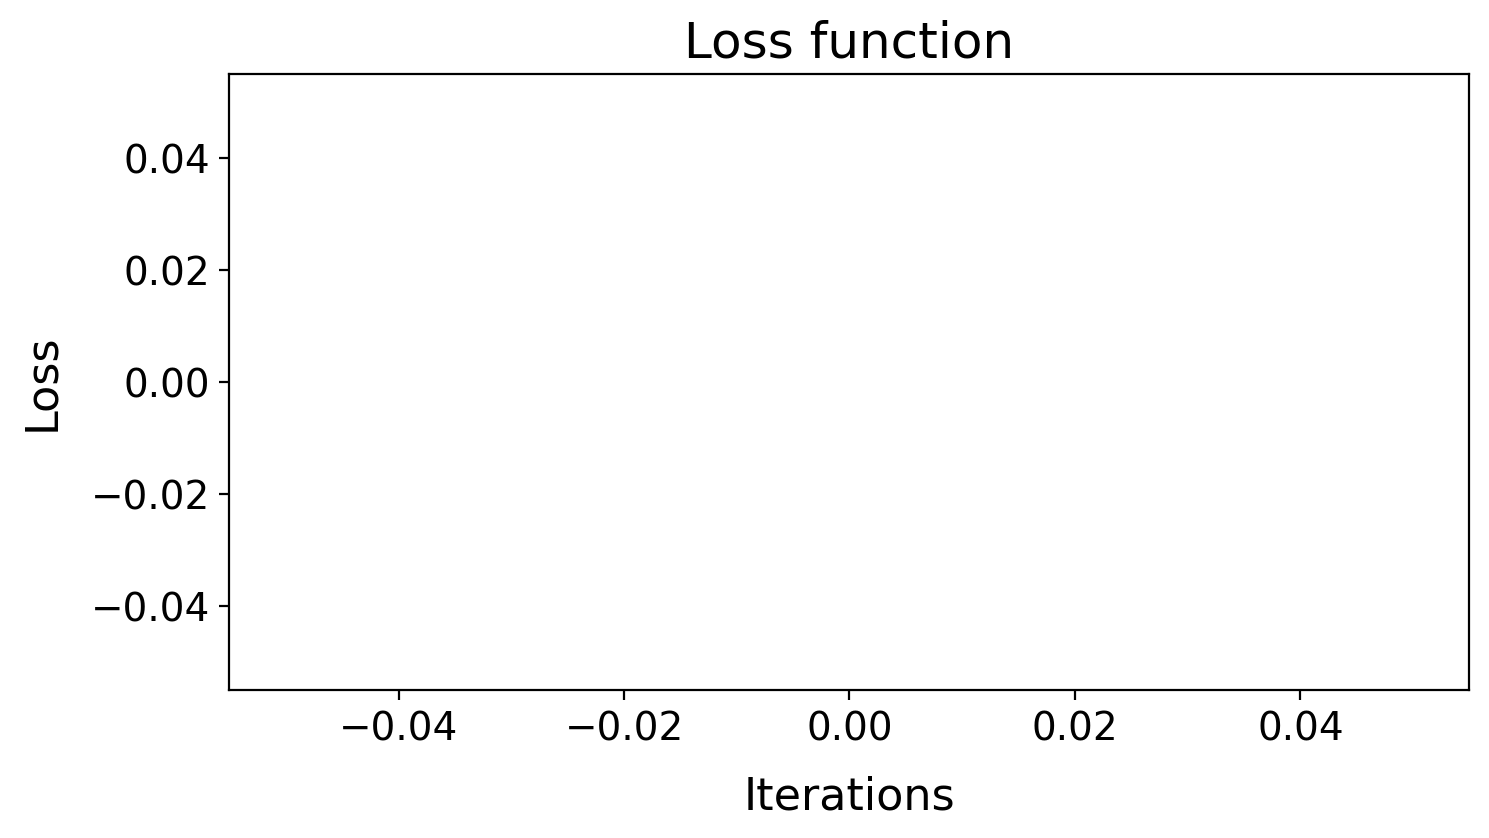

In [123]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(loss_cache[:])
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [20]:
para_cache[para_cache==-1] = np.nan

(2000, 4)
(2000,)
(2000,)


Text(0, 0.5, 'Loss')

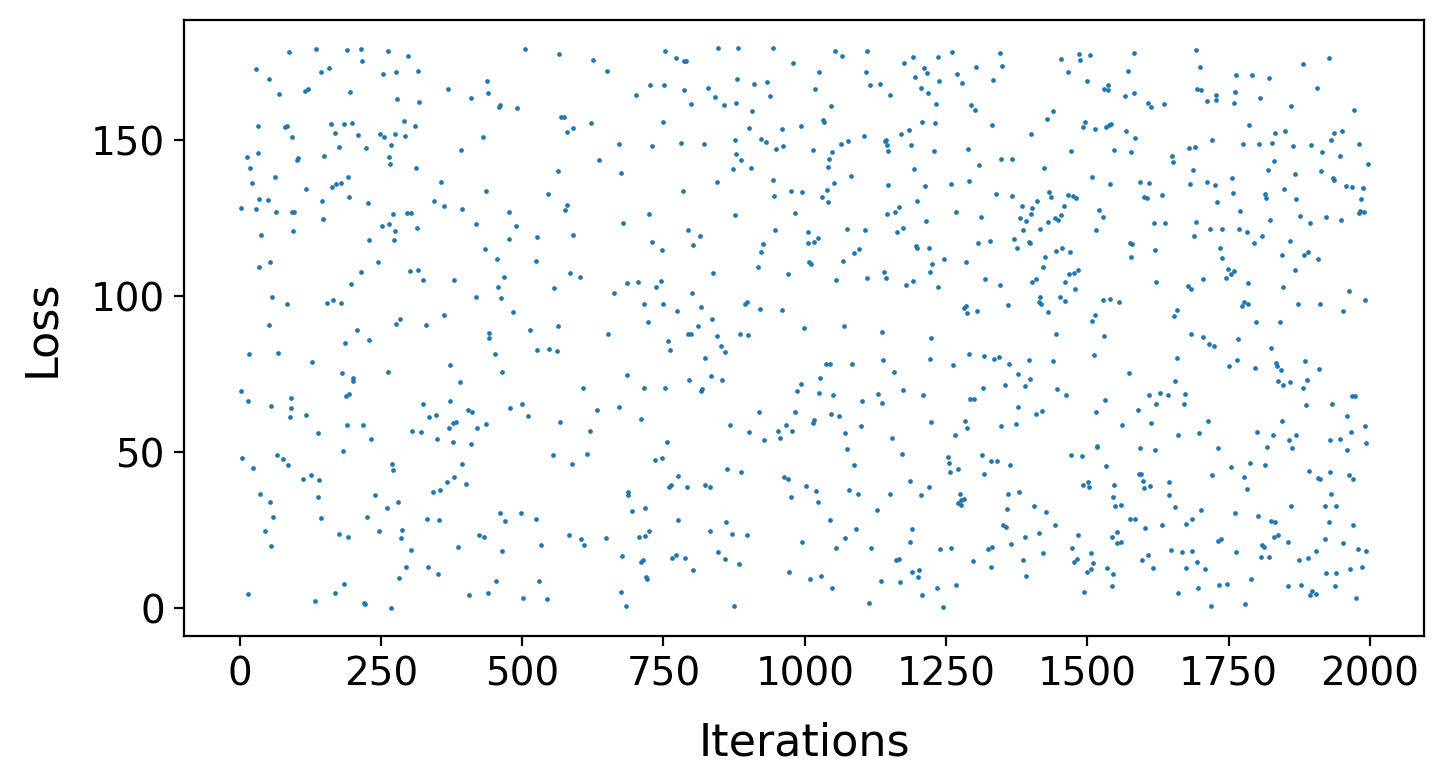

In [29]:
#plt.rcParams["figure.figsize"] = (8, 4) 
print(para_cache.shape)
print(np.arange(2000).shape)
iter_num = 2000
print(para_cache[:,2].shape)
plt.scatter(np.arange(iter_num),para_cache[:,2],s = 0.5)
#plt.plot(para_cache[:,1],'.')
#plt.hist(para_cache[:,2])
#plt.hist(para_cache[:,3])
#plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Mean and variance

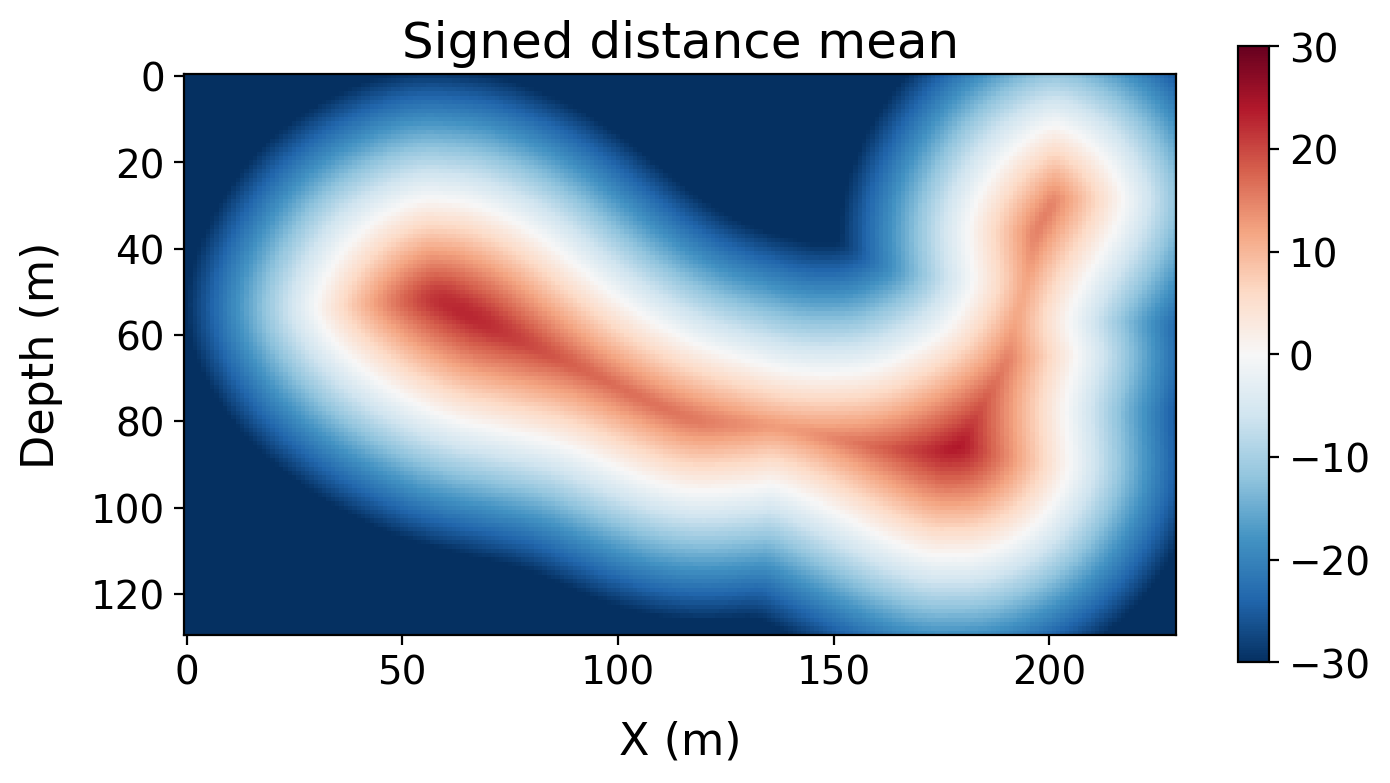

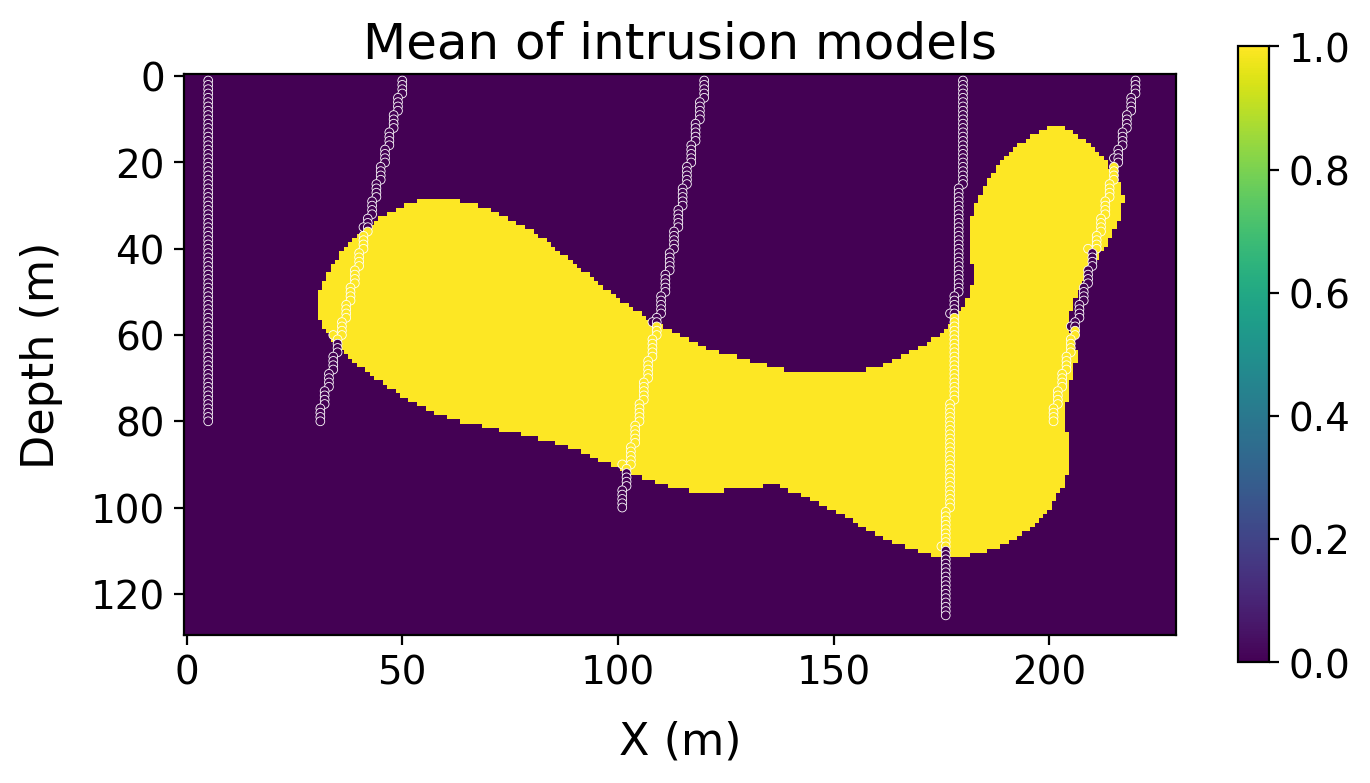

In [30]:
plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0),vmin = -30,vmax =30,cmap = 'RdBu_r')
plt.colorbar()
plt.title('Signed distance mean')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0)>0)
plt.colorbar()
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Mean of intrusion models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

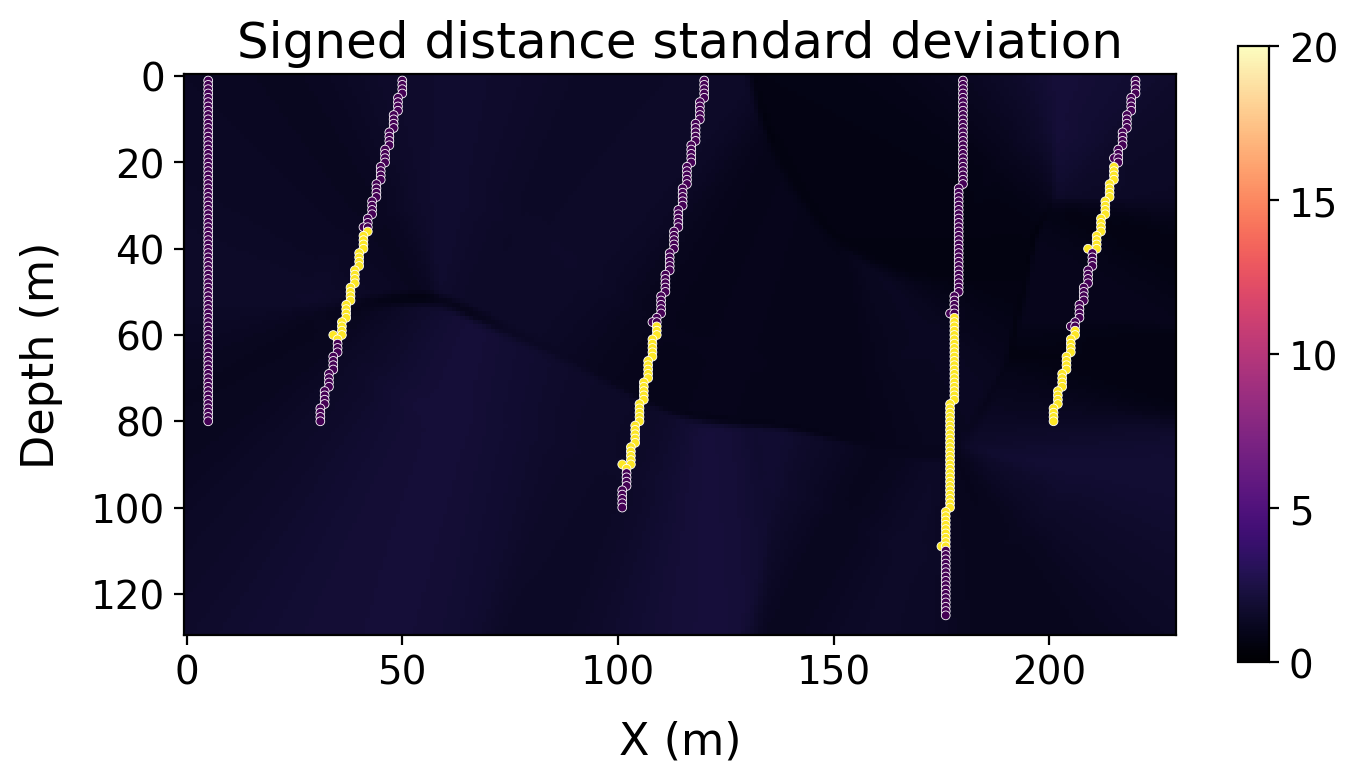

In [31]:
plt.imshow(np.std(model_cache[1000:,:,:],axis = 0),vmin = 0,vmax = 20, cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

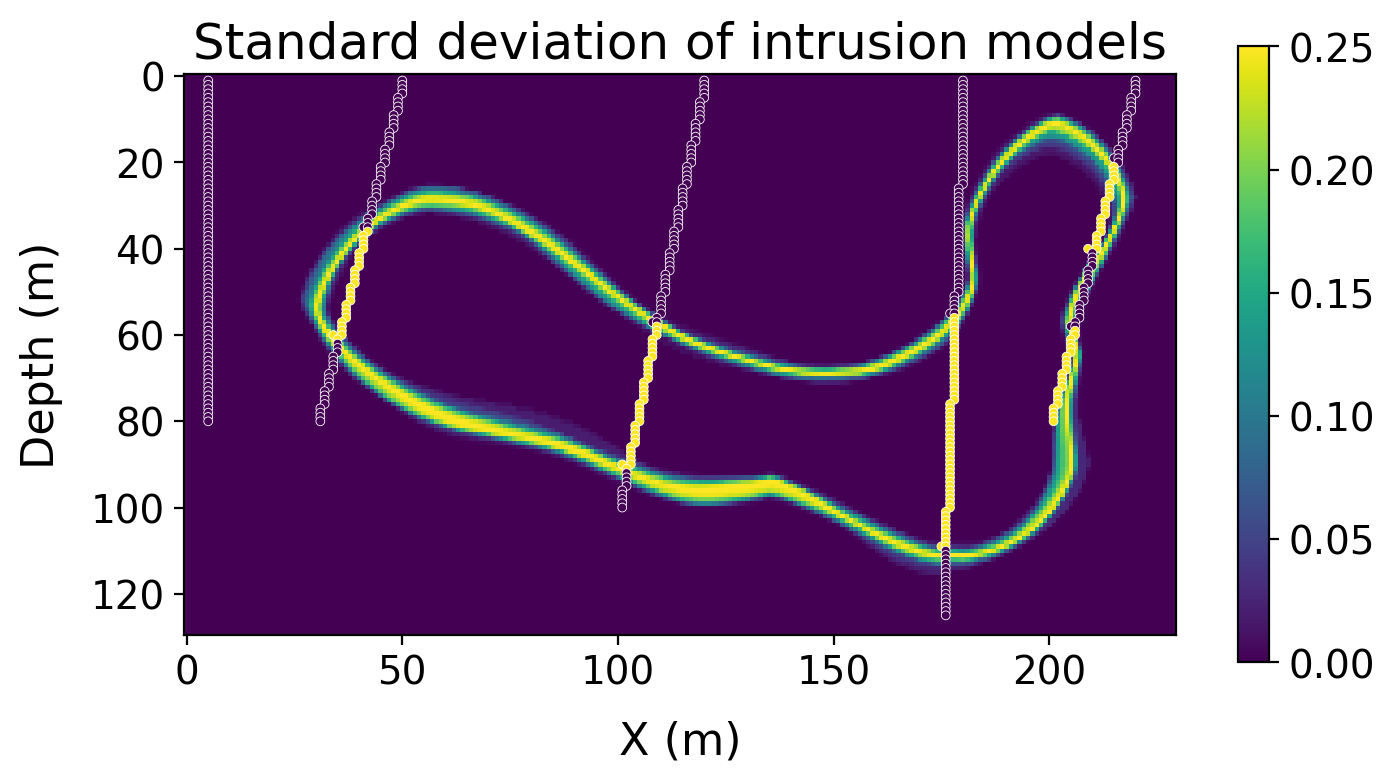

In [32]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

In [33]:
# plt.imshow((np.mean(model_cache[1000:,:,:],axis = 0)-np.std(model_cache[1000:,:,:],axis = 0))>0)
# plt.colorbar()
# plt.title('Signed distance standard deviation')
# plt.scatter(borehole['x'], borehole['depth'],
#             c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
# plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
# plt.show()

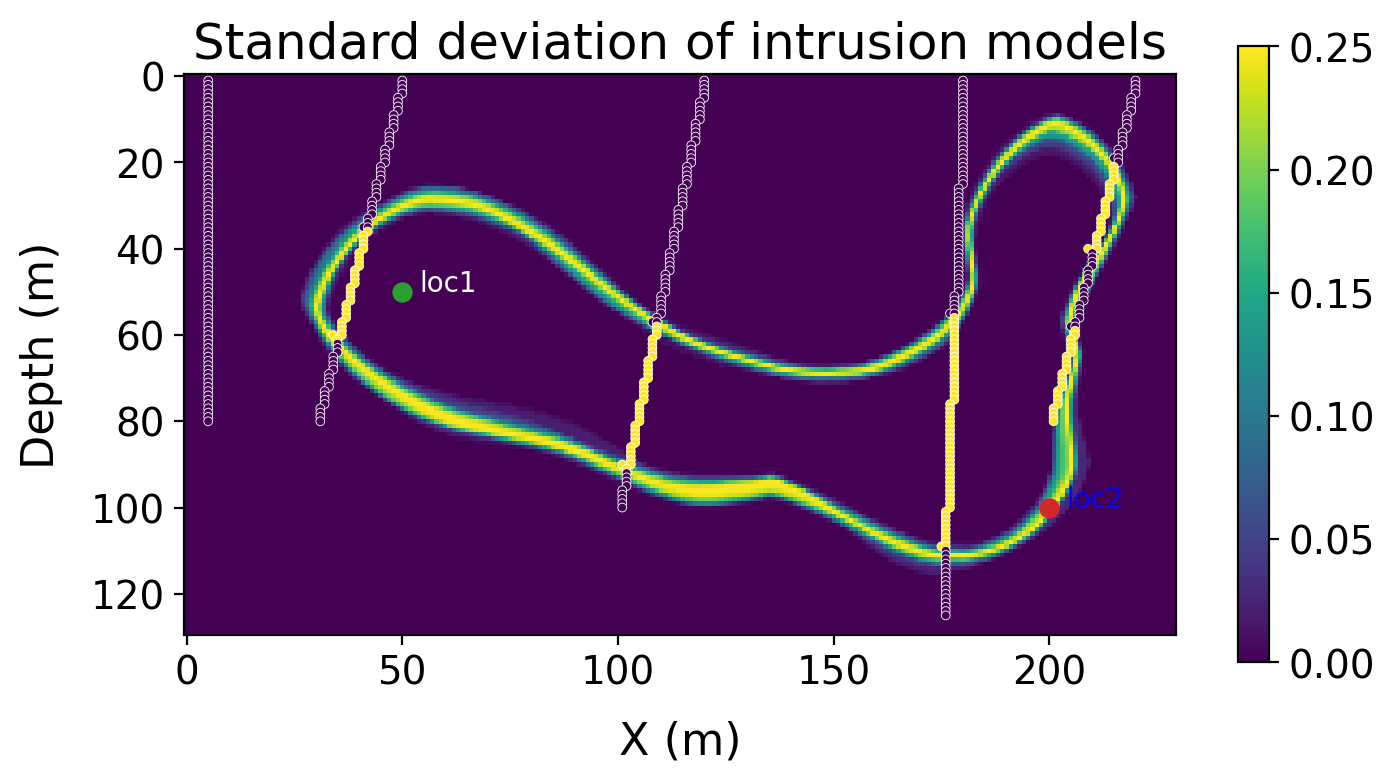

In [34]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)

plt.scatter(50,50,c = 'C2',s = 40)
plt.text(50+4,50,'loc1',color = 'w')
plt.scatter(200,100,c = 'C3',s = 40)
plt.text(200+4,100,'loc2',color = 'b')

plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

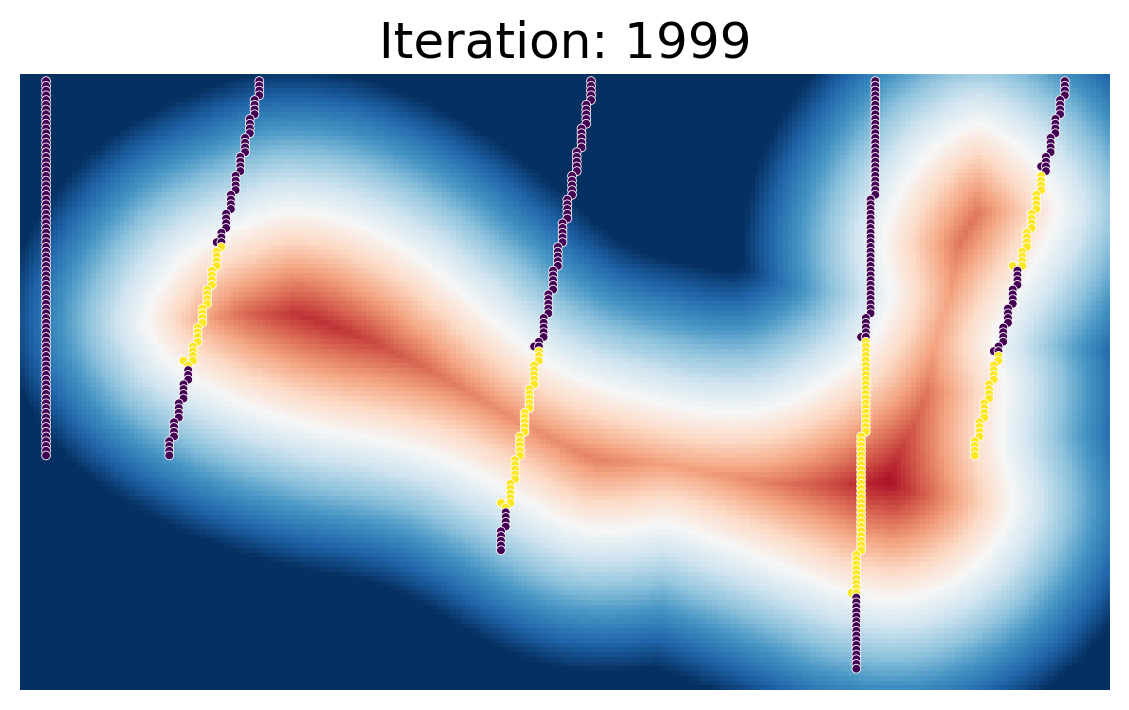

In [37]:
idx = 2000 - 1

plt.imshow(model_cache[idx,:,:],vmin = -30,vmax =30,cmap = 'RdBu_r')
#plt.colorbar()
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Iteration: '+str(idx))
#plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.axis('off')
plt.show()

## Convergence

In [38]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

Text(0.5, 1.0, 'Trace plot')

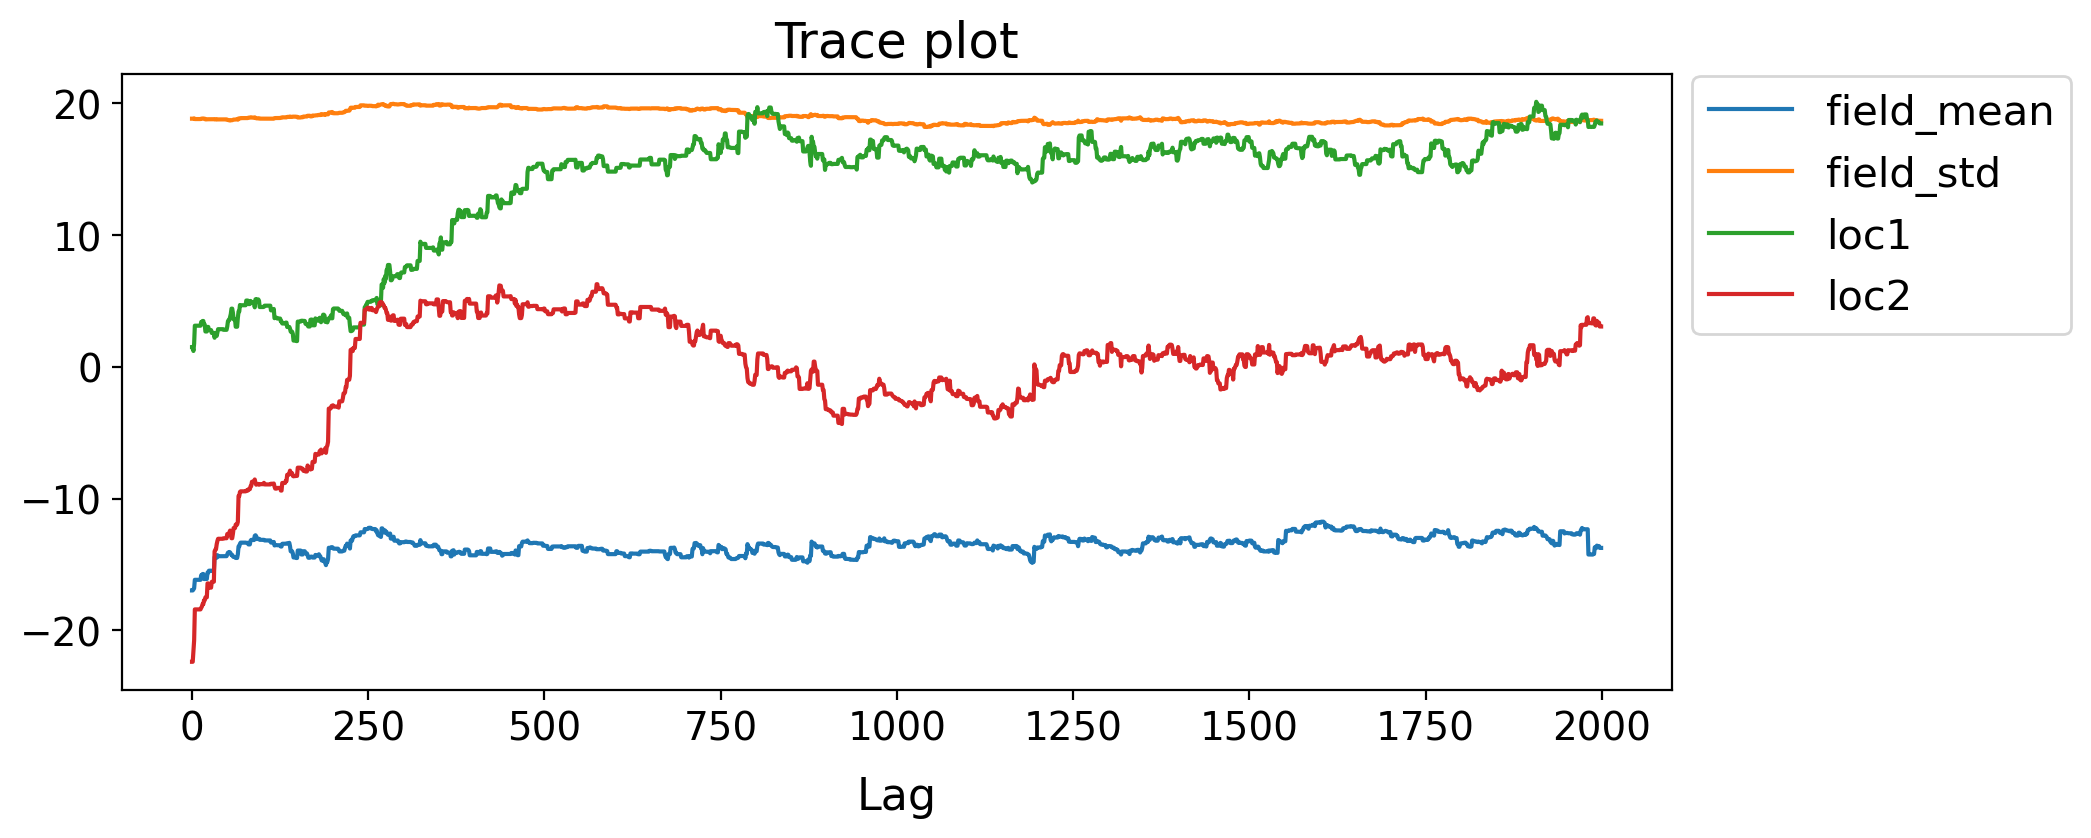

In [40]:
iter_num = 2000
model_cache_mean = np.mean(model_cache.reshape(iter_num,-1),axis = 1)
model_cache_std = np.std(model_cache.reshape(iter_num,-1),axis = 1)
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (10, 4) 
plt.plot(model_cache_mean,label = 'field_mean')
plt.plot(model_cache_std,label = 'field_std')

plt.plot(model_cache[:,50,50],label = 'loc1')
plt.plot(model_cache[:,100,200],label = 'loc2')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

## ACF

In [43]:
cut_off = 200
from statsmodels.tsa.stattools import acf
acf_values = np.zeros((1800,model_cache.shape[1],model_cache.shape[2]))
for i in tqdm(range(model_cache.shape[1])):
    for j in range(model_cache.shape[2]):
        acf_values[:,i,j] = acf(model_cache[cut_off:,i,j],nlags = 10000)

100%|██████████| 130/130 [00:03<00:00, 36.39it/s]


(1800, 130, 230)


Text(0.5, 1.0, 'Mean autocorrelation of all grids')

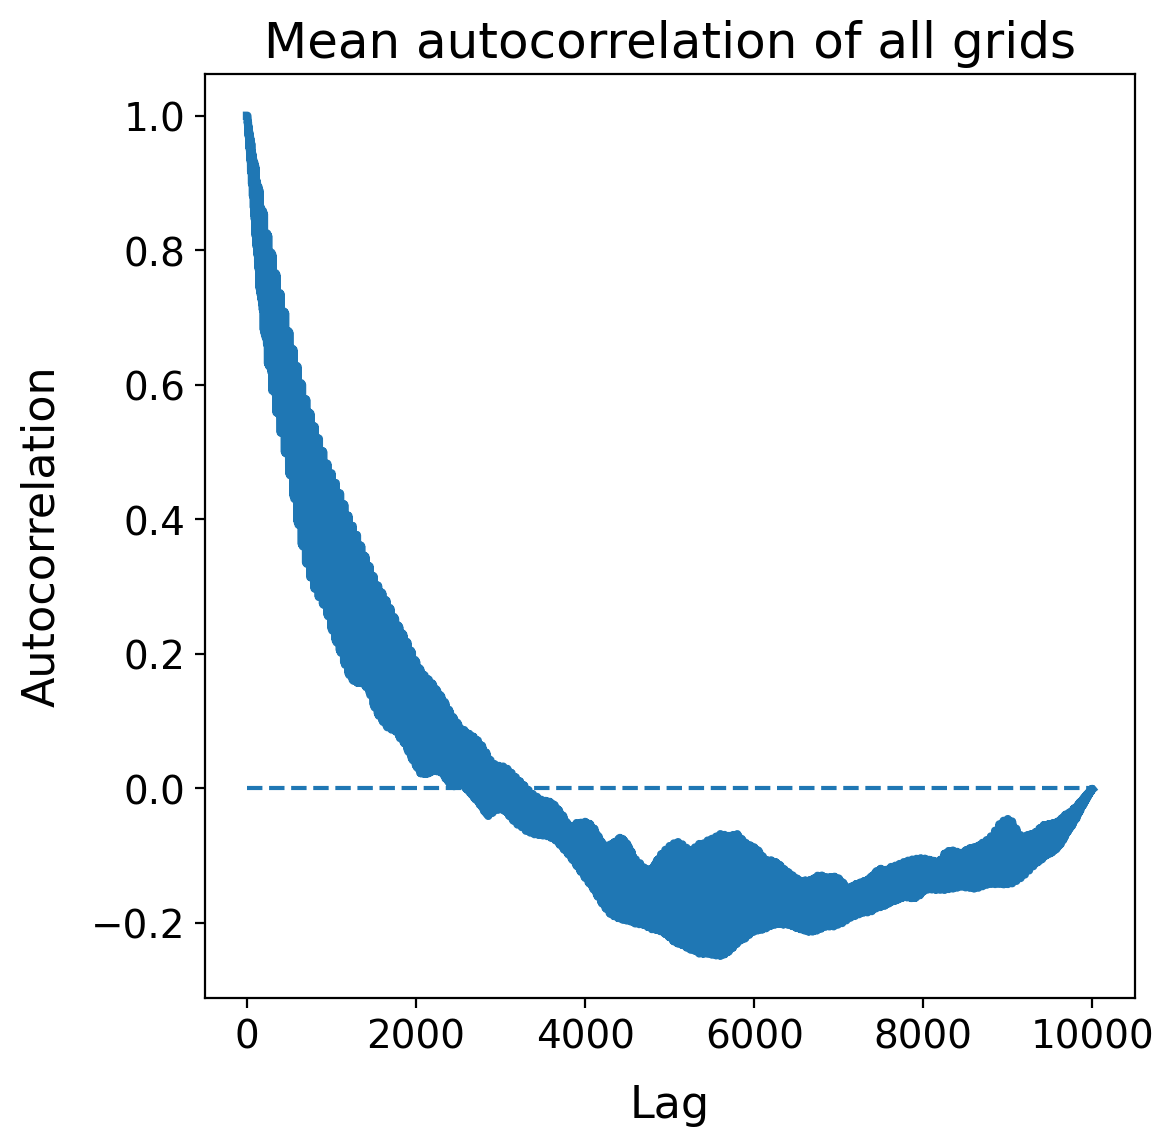

In [48]:
plt.rcParams["figure.figsize"] = (6, 6) 
print(acf_values.shape)
plt.plot(np.mean(acf_values.reshape(10000,-1),axis =1),linewidth = 3)
plt.hlines(xmin = 0, xmax = 10000,y = 0,linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Mean autocorrelation of all grids')

In [49]:
### acceptance rate curve
acc_rate = np.zeros(iter_num)
acc_rate[:] = np.nan

for iteration in np.arange(1,iter_num):
    acc_rate[iteration] = 1-np.sum((loss_cache[1:(iteration+1)]-loss_cache[0:iteration])==0)/iteration

Text(0.5, 1.0, 'Acceptance rate')

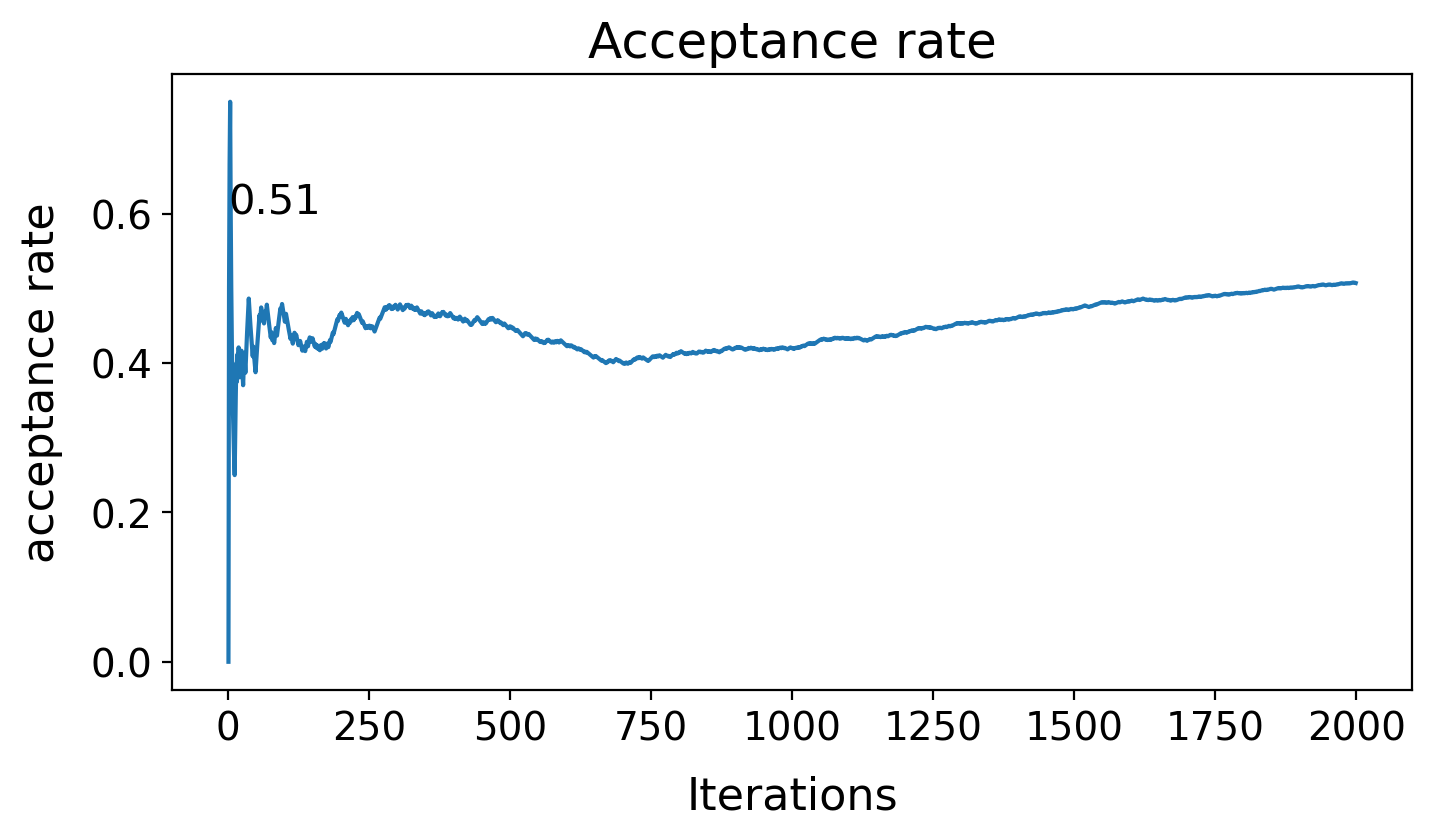

In [50]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(np.arange(1,iter_num),acc_rate[1:])
plt.text(iter_num-2000, 0.5+0.1, np.round(acc_rate[-1],2))
plt.ylabel('acceptance rate')
plt.xlabel('Iterations')
plt.title('Acceptance rate')

# Residual simulation, velocity extension on each trend

## Step 1: Calculate the signed distance for each contact point in our data

In [51]:
idx_at_contact = np.abs(np.gradient(data,axis = 0))>0

In [53]:
mc_pos_sdf = np.copy(model_cache[cut_off:,:,:])
sdf_at_contact = np.zeros((mc_pos_sdf.shape[0],np.sum(idx_at_contact)))
for i in tqdm(range(mc_pos_sdf.shape[0])):
    #mc_pos_sdf[i,:,:] = skfmm.distance(mc_pos[i,:,:]-0.5)
    sdf_at_contact[i,:] = mc_pos_sdf[i,:,:][idx_at_contact]

100%|██████████| 1800/1800 [00:00<00:00, 60072.15it/s]


Text(0.5, 1.0, 'Histogram of signed distance at the contact points')

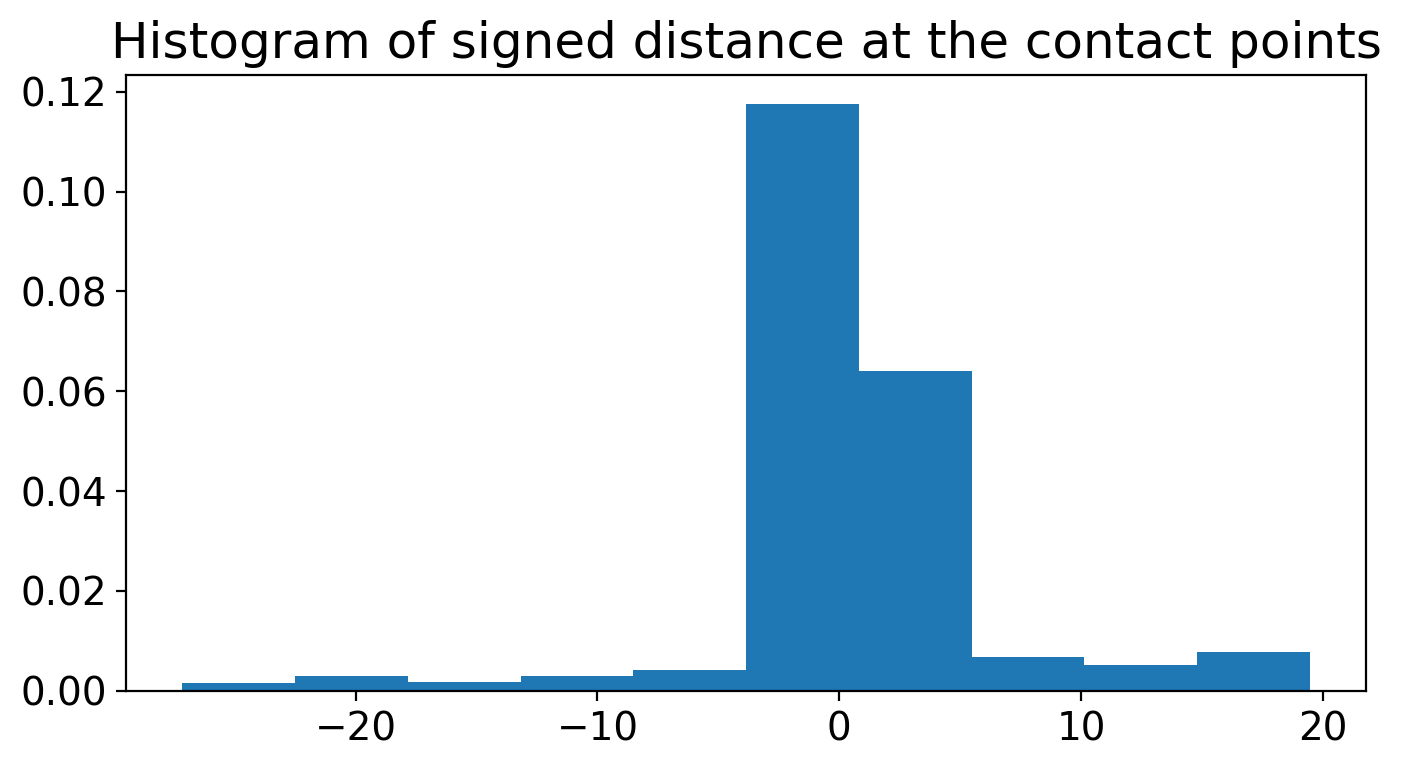

In [54]:
plt.hist(sdf_at_contact.reshape(-1),density = True)
plt.title('Histogram of signed distance at the contact points')

In [55]:
plus_pos = mc_pos_sdf[:,data==1]
minus_pos = mc_pos_sdf[:,data==0]

Text(0.5, 1.0, 'Borehole accuracy')

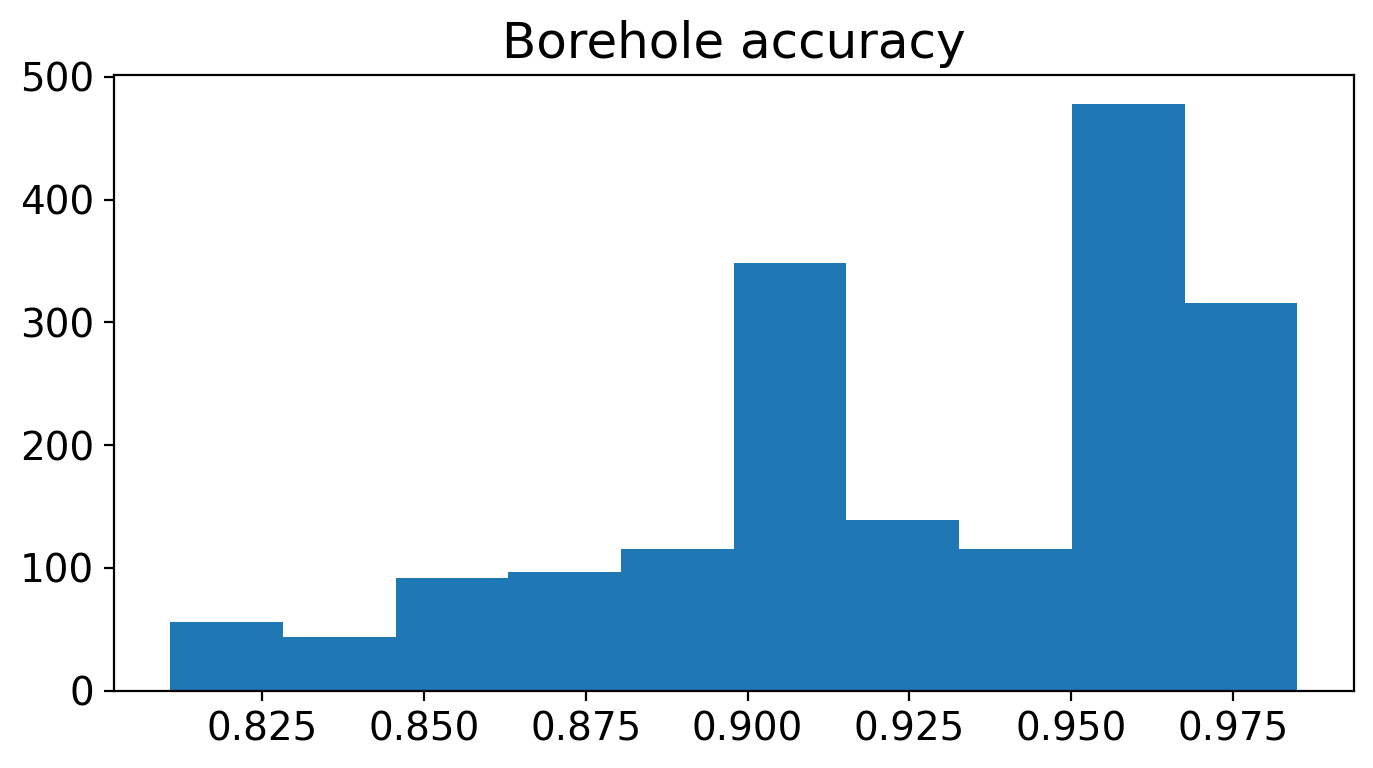

In [56]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0,axis = 1)+np.sum(minus_pos<0,axis = 1))/(np.sum(data==0)+np.sum(data==1)))
plt.title('Borehole accuracy')

## Step 2: M(x) + R(x), Construct velocity with the above variance and do velocity extension

In [57]:
variance = np.var(sdf_at_contact.reshape(-1))

In [61]:
def extension_with_large_velocity(model):
    nx, ny = model.shape
    velocity = generate_m_2D([0,variance,20,20, np.random.uniform(0,180)], np.arange(nx), np.arange(ny), seed = None)
    # Here I choose the range 20 because trend can capture large scale variances larger than 20. 
    [_, F_eval] = skfmm.extension_velocities(model, velocity, dx=[1, 1],order = 1)
    
    max_iter_num = int(np.ceil(np.max(np.abs(F_eval))))
    for ii in range(max_iter_num):
        dt = 1/np.ceil(np.max(np.abs(F_eval)))
        delta_phi = dt * F_eval
        model_next = model - delta_phi # Advection
        model = skfmm.distance(model_next)
    return model

In [62]:
mc_pos_sdf_selected = model_cache[np.arange(cut_off,iter_num,100),:,:]

In [63]:
mc_pos_sdf_plus_residual = np.zeros(mc_pos_sdf_selected.shape)
for i in tqdm(range(mc_pos_sdf_selected.shape[0])):
    mc_pos_sdf_plus_residual[i,:,:] = extension_with_large_velocity(mc_pos_sdf_selected[i,:,:])

100%|██████████| 18/18 [00:08<00:00,  2.24it/s]


## Step 3:  M(x) + R(x) with perfect match, Ensemble smoother for final matches

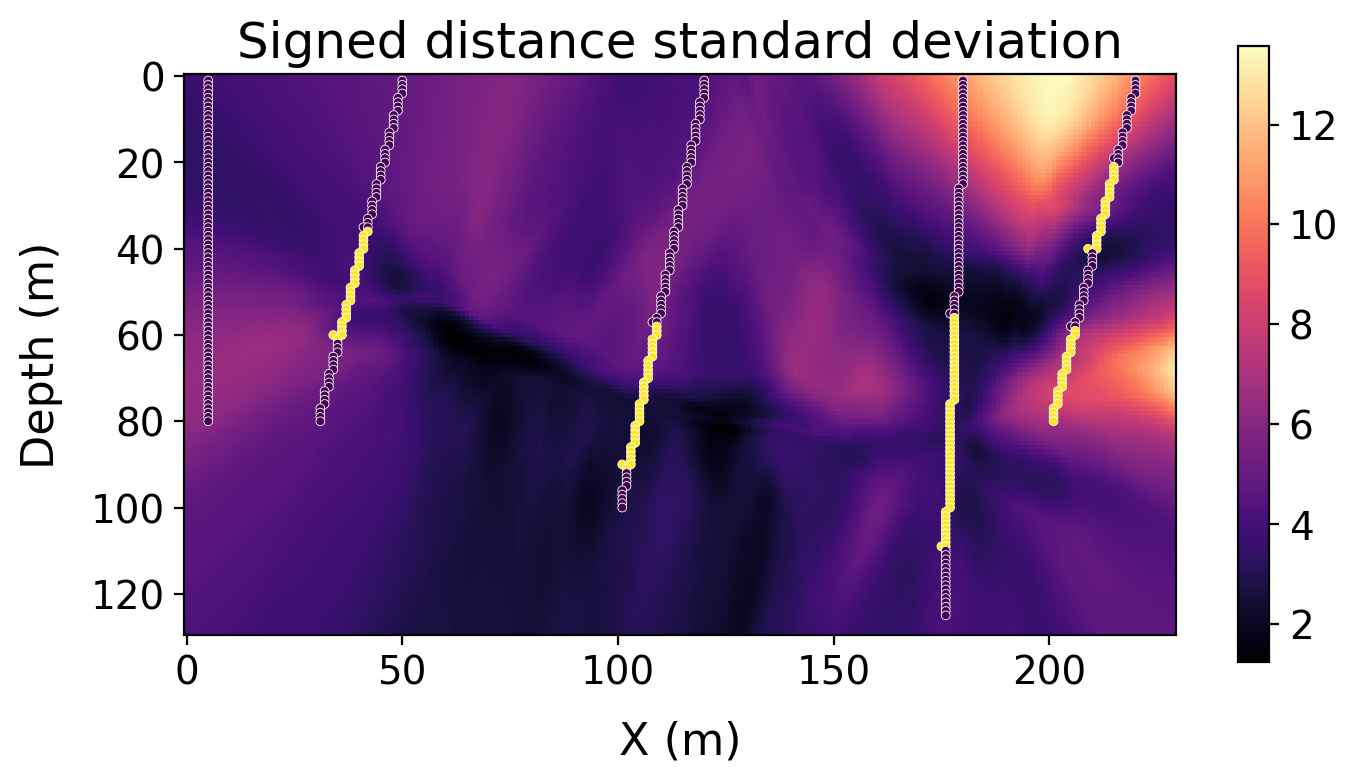

In [64]:
plt.imshow(np.std(mc_pos_sdf_plus_residual[:,:,:],axis = 0)-np.std(model_cache[1000:,:,:],axis = 0), cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

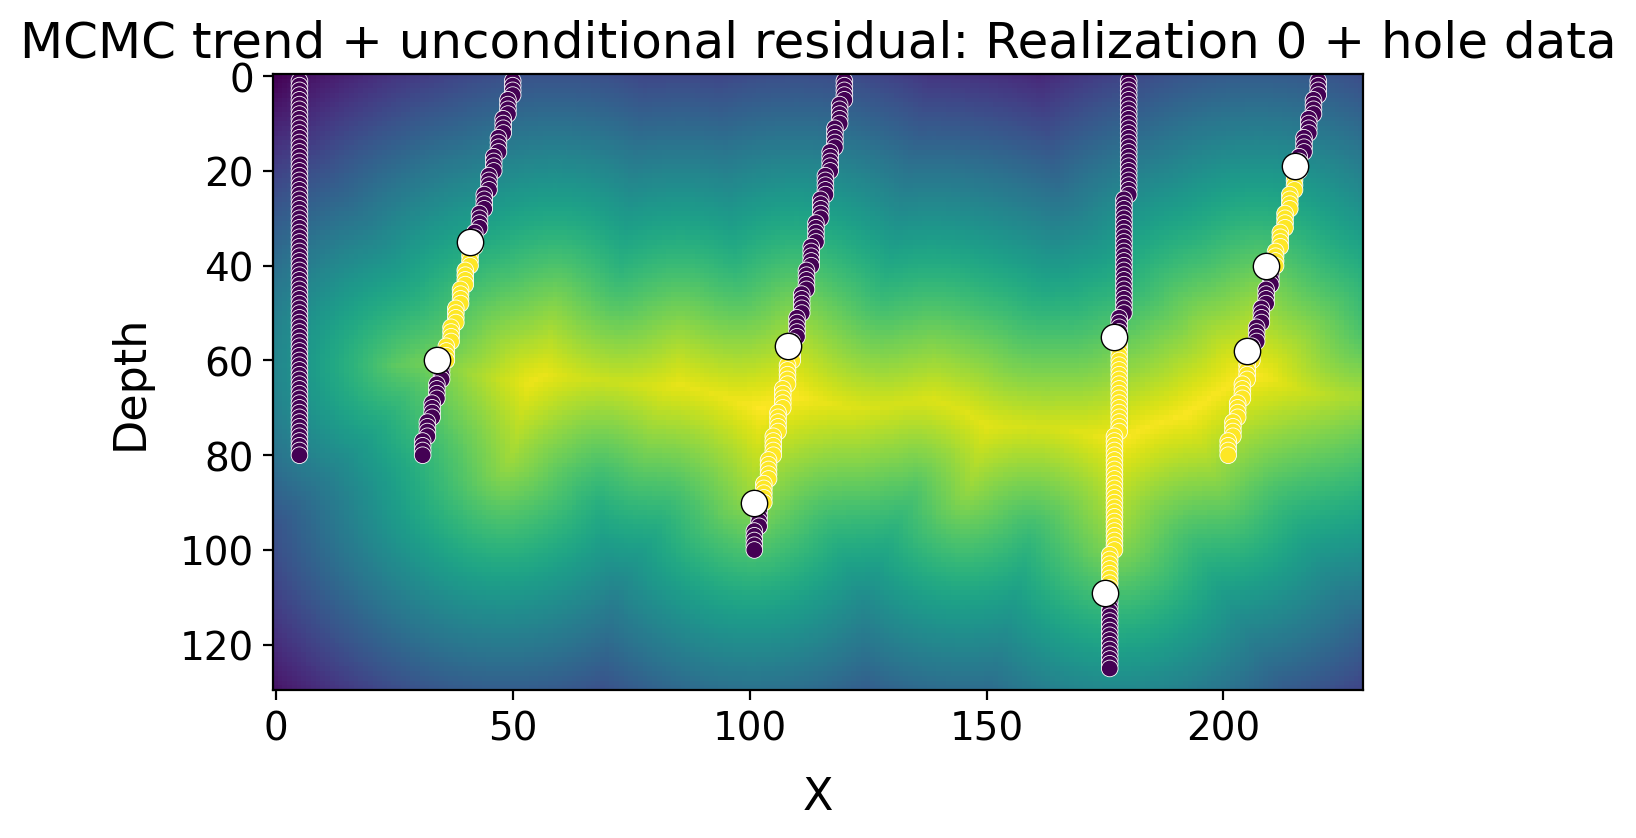

In [65]:
idx = 0
plt.imshow(mc_pos_sdf_plus_residual[idx,:,:])
plt.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
plt.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)

plt.title('MCMC trend + unconditional residual: Realization '+str(idx)+' + hole data')
plt.ylabel('Depth'), plt.xlabel('X')
plt.show()

In [66]:
# Sigmoid on DT
def sigmoid(prior_DT):
    return 1/(1 + np.exp(-prior_DT*10))

def ensemble_smoother(m,d,d_obs):
    # no measurement error for now
    # covaraince matrix of d: cov_d
    cov_d = np.cov(d)
    # cross-covariance matrix: cov_m_d, m can be very large so I split into small piece and calculate the covariance matrix.
    start = 0
    sep = 1000
    cov_m_d = np.zeros((m.shape[0],d.shape[0]))
    for end in np.arange(0,m.shape[0],sep)+sep:
        cov_m_d[start:end,:] = np.cov(m[start:end,:],d)[:m[start:end,:].shape[0],m[start:end,:].shape[0]:]
        start = end

    K = np.dot(cov_m_d, np.linalg.inv(cov_d))
    m_pos = m + np.dot(K,d_obs-d)

    return m_pos

In [67]:
mc_pos_sdf_plus_residual_S_DT = sigmoid(mc_pos_sdf_plus_residual)

/private/tmp/PKInstallSandbox.fuEKsq/tmp/ipykernel_55846/1161685376.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-prior_DT*10))


In [68]:
data[data == 0.5] = np.nan
d = mc_pos_sdf_plus_residual_S_DT[:,~np.isnan(data)]
d_obs = data[~np.isnan(data)]

d_obs = d_obs[np.var(d,axis = 0)>1e-6] # only invert boreholes with variance > 0.05. Mathemtically > 0 should be fine. 
d = d[:,np.var(d,axis = 0)>1e-6]

In [69]:
mc_pos_sdf_plus_residual_S_DT_pos = ensemble_smoother(mc_pos_sdf_plus_residual_S_DT.reshape(mc_pos_sdf_selected.shape[0],-1).T,
                                                      d.T,d_obs.reshape(-1,1)).T

In [72]:
def vis_ensembles_mean_var(plot_model):
    
    plt.rcParams['figure.figsize'] = 32, 10
    fig, axs = plt.subplots(1, 5)
    i = 0
    for ax in axs.flat[:3]:
        ax.imshow(plot_model[i*1+1,:,:]>0.5,vmin = 0, vmax = 1)
        ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
        ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
                    c='w', edgecolors='k', linewidths=0.5,s=90)
        ax.axis('off')
        ax.set_title('Realization '+str(i*100+1),fontsize = 25)
        i = i + 1

    ax = axs.flat[3]
    ax.imshow(np.mean(plot_model,axis = 0),vmin = 0, vmax = 1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)
    ax.axis('off')
    ax.set_title('Mean',fontsize = 25)

    ax = axs.flat[4]
    ax.imshow(np.var(plot_model,axis = 0),vmin = 0, vmax = 0.1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)    
    ax.axis('off')
    ax.set_title('Variance',fontsize = 25)

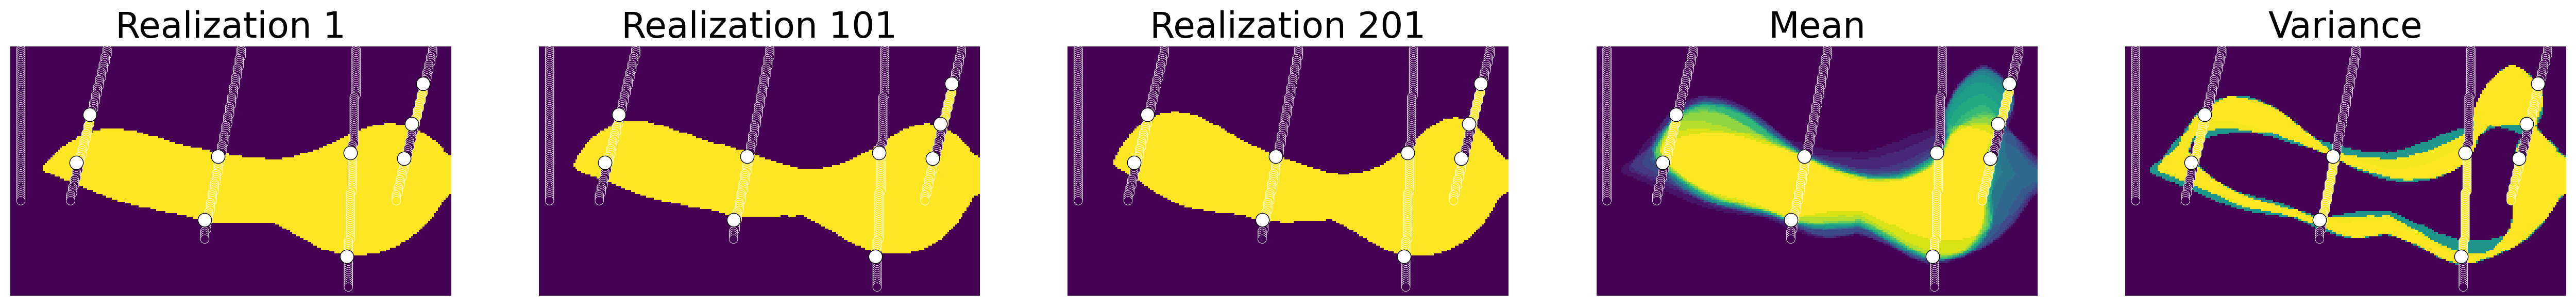

In [73]:
vis_ensembles_mean_var((mc_pos_sdf_selected>0)*1)

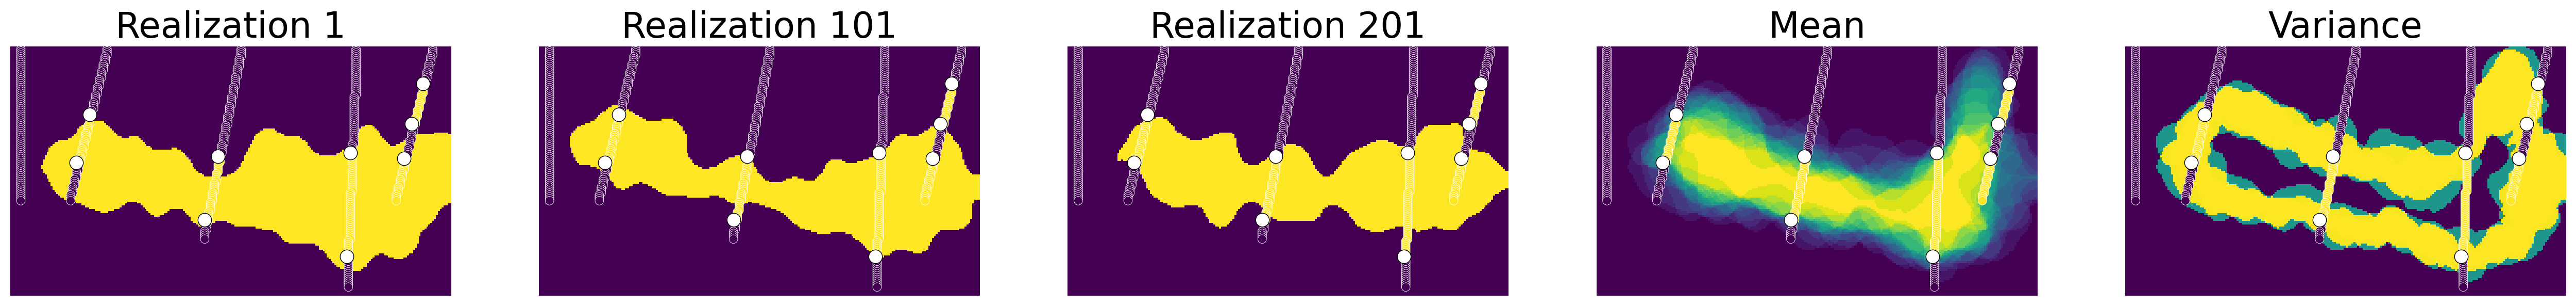

In [74]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT>0.5)*1)

In [75]:
mc_pos_sdf_plus_residual_S_DT_pos = mc_pos_sdf_plus_residual_S_DT_pos.reshape(mc_pos_sdf_selected.shape)

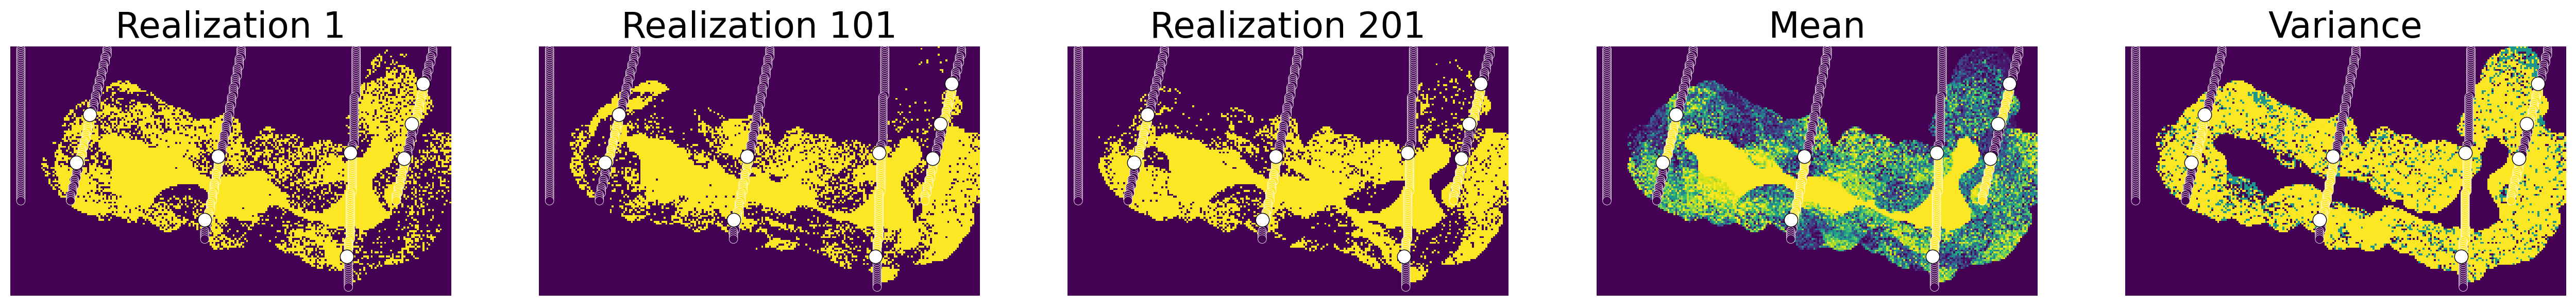

In [76]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT_pos>0.5)*1)

In [77]:
plus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==1]
minus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==0]

(array([1., 3., 1., 3., 4., 1., 1., 2., 1., 1.]),
 array([0.68387097, 0.69290323, 0.70193548, 0.71096774, 0.72      ,
        0.72903226, 0.73806452, 0.74709677, 0.75612903, 0.76516129,
        0.77419355]),
 <BarContainer object of 10 artists>)

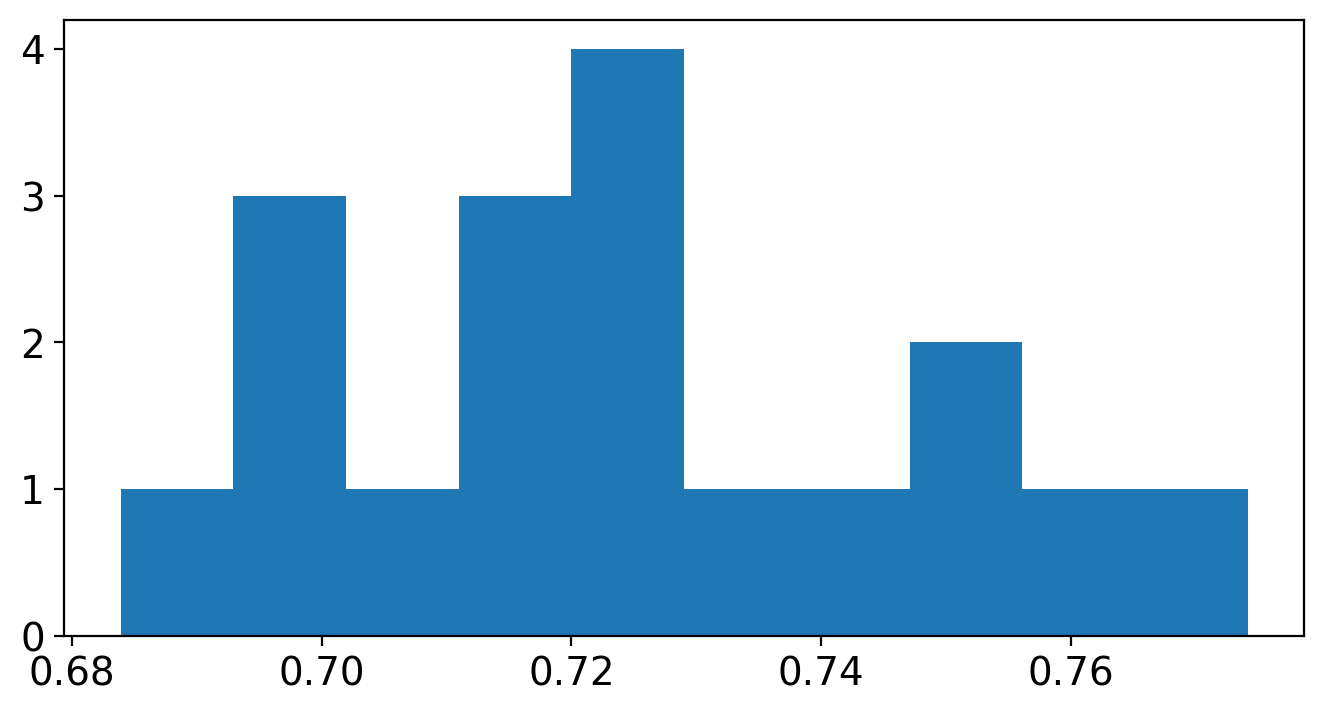

In [78]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0.5,axis = 1)+np.sum(minus_pos<=0.5,axis = 1))/(np.sum(data==0)+np.sum(data==1)))